In [9]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import model as m
import plot
import predict

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

import umap
import matplotlib
from sklearn.preprocessing import StandardScaler

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load experiment

Text(0, 0.5, 'Mean LL')

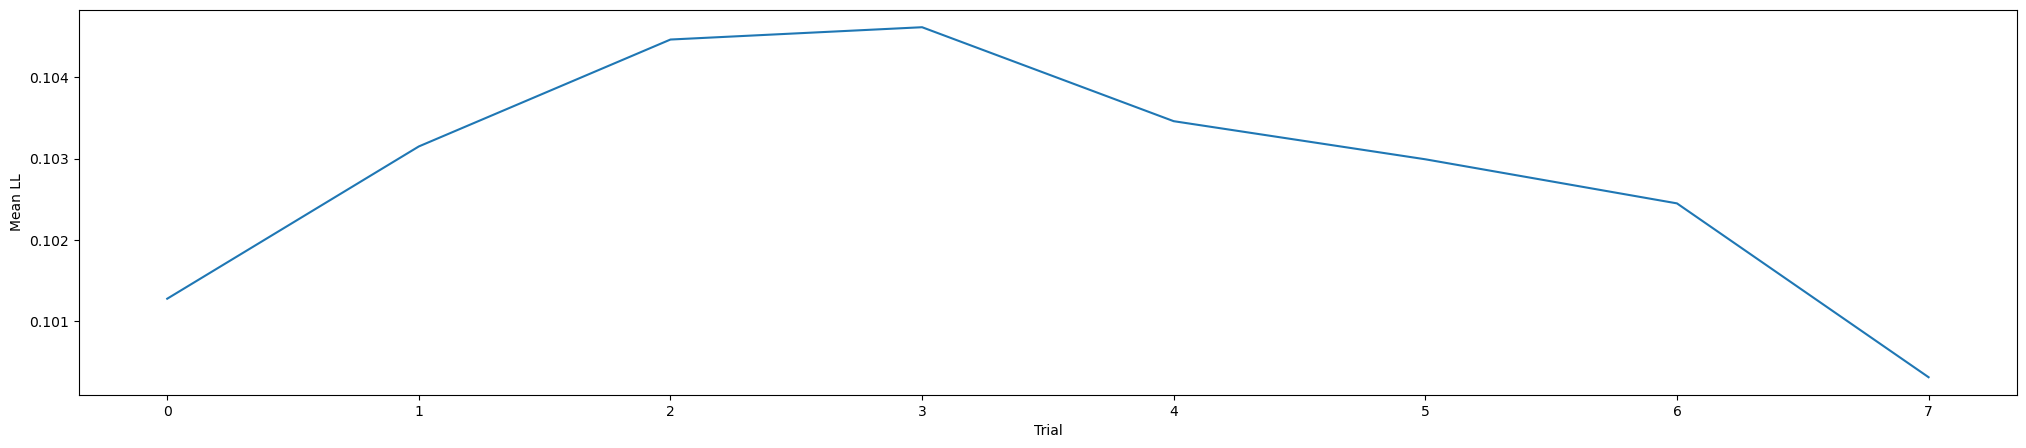

In [10]:
expts = ['expt04', 'expt06', 'expt07', 'expt09', 'expt11']
num_subunits = 12
num_inh = 6
num_iterses = [2,3,4,5,6,7,8,9]
#e = exp.load('iter_exps03', experiment_location='experiments', datadir='Mdata')
es = []
best_trials = []
for i in num_iterses:
    e = exp.load('iter_exps07_'+str(i)+'iters', experiment_location='experiments', datadir='Mdata')
    es.append(e)
    # add the trials with the best LLs to the list
    best_trials.append(e.trials[np.argmax([np.mean(trial.LLs) for trial in e.trials])])

# plot the mean LLs for the best_trials in a line chart
fig= plt.figure(figsize=(25,5))
plt.plot([np.mean(trial.LLs) for trial in best_trials])
plt.xlabel('Trial')
plt.ylabel('Mean LL')

In [11]:
# get experiment boundaries (they all use the same dataset)
dataset = best_trials[0].dataset
expt_boundaries = np.concatenate([[0], np.cumsum(dataset.num_units)])
expt_boundaries

lazy loading dataset
Loading ['expt04', 'expt06', 'expt07', 'expt09', 'expt11']
Loading expt04
  Time embedding...
  Done.
Loading expt06
  Time embedding...
  Done.
Loading expt07
  Time embedding...
  Done.
Loading expt09
  Time embedding...
  Done.
Loading expt11
  Time embedding...
  Done.


array([  0,  35,  63,  91, 114, 139])

In [3]:
es[2].trials_df

,trial_idx,model_name,expt,num_iter,num_filters,layer1_num_lags,name,trial,mean_LLs
0,0,TconvScaffoldIter,expt04+expt06+expt07+expt09+expt11,4,12,2,TconvScaffoldIter0,<experiment.Trial object at 0x7fbdc873b460>,0.095434
0,1,TconvScaffoldIter,expt04+expt06+expt07+expt09+expt11,4,12,2,TconvScaffoldIter1,<experiment.Trial object at 0x7fbdc8853f40>,0.100324
0,2,TconvScaffoldIter,expt04+expt06+expt07+expt09+expt11,4,12,2,TconvScaffoldIter2,<experiment.Trial object at 0x7fbdc889e640>,0.075958
0,3,TconvScaffoldIter,expt04+expt06+expt07+expt09+expt11,4,12,2,TconvScaffoldIter3,<experiment.Trial object at 0x7fbdc882efa0>,0.102687
0,4,TconvScaffoldIter,expt04+expt06+expt07+expt09+expt11,4,12,2,TconvScaffoldIter4,<experiment.Trial object at 0x7fbdc882e3a0>,0.104464


In [4]:
# print the reg_vals for the best_models
for trial in best_trials:
    trial.model.print_params('reg_vals')

core
0 {'d2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
1 {'activity': 0, 'd2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
readout
0 None
core
0 {'d2xt': 0.00010000000000000002, 'center': 0.0, 'bcs': {'d2xt': 1}}
1 {'activity': 0.006075861442805143, 'd2xt': 9.999999999999999e-05, 'center': 0.0, 'bcs': {'d2xt': 1}}
readout
0 None
core
0 {'d2xt': 0.0001, 'center': 0.0, 'bcs': {'d2xt': 1}}
1 {'activity': 0.02864197002493942, 'd2xt': 0.0001, 'center': 0.0, 'bcs': {'d2xt': 1}}
readout
0 None
core
0 {'d2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
1 {'activity': 0.005, 'd2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
readout
0 None
core
0 {'d2xt': 0.0001, 'center': 0.0, 'bcs': {'d2xt': 1}}
1 {'activity': 0.0, 'd2xt': 0.0001, 'center': 0.0, 'bcs': {'d2xt': 1}}
readout
0 None
core
0 {'d2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
1 {'activity': 0, 'd2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
readout
0 None
core
0 {'d2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
1 {'activity': 0.005, '

In [5]:
# # plot the mean LLs for all the trials in a line chart
# fig, ax = plt.subplots(figsize=(25,5))
# mean_LLs = [np.mean(trial.LLs) for trial in e.trials]
# max_LL = np.max(mean_LLs)
# # get the index of the max LL
# max_LL_idx = np.argmax(mean_LLs)
# # print the reg_vals for the trial with the max LL
# e.trials[max_LL_idx].model.print_params('reg_vals')
# 
# ax.plot(mean_LLs)
# 
# # put a horizontal dashed line at the max LL
# ax.axhline(y=np.max(mean_LLs), color='red', linestyle='--', alpha=0.5)
# # put an asterisk at the max LL as well
# ax.scatter(np.argmax(mean_LLs), np.max(mean_LLs), marker='*', s=100, color='r', label='max ['+str(max_LL)+']', alpha=0.5)
# 
# # put a vertical dashed line at x=4 and x=10
# ax.axvline(x=8, color='gray', linestyle='--', label='fixed', alpha=0.5)
# ax.axvline(x=32, color='k', linestyle='--', label='random', alpha=0.5)
# ax.axvline(x=90, color='g', linestyle='--', label='optimized', alpha=0.5)
# ax.legend()
# ax.set_xlabel('Trial')
# ax.set_ylabel('Mean LL')
# ax.set_title('mean LLs for model after 16 random samples, optimization for 50 steps')
# plt.show()

# plot matched filters

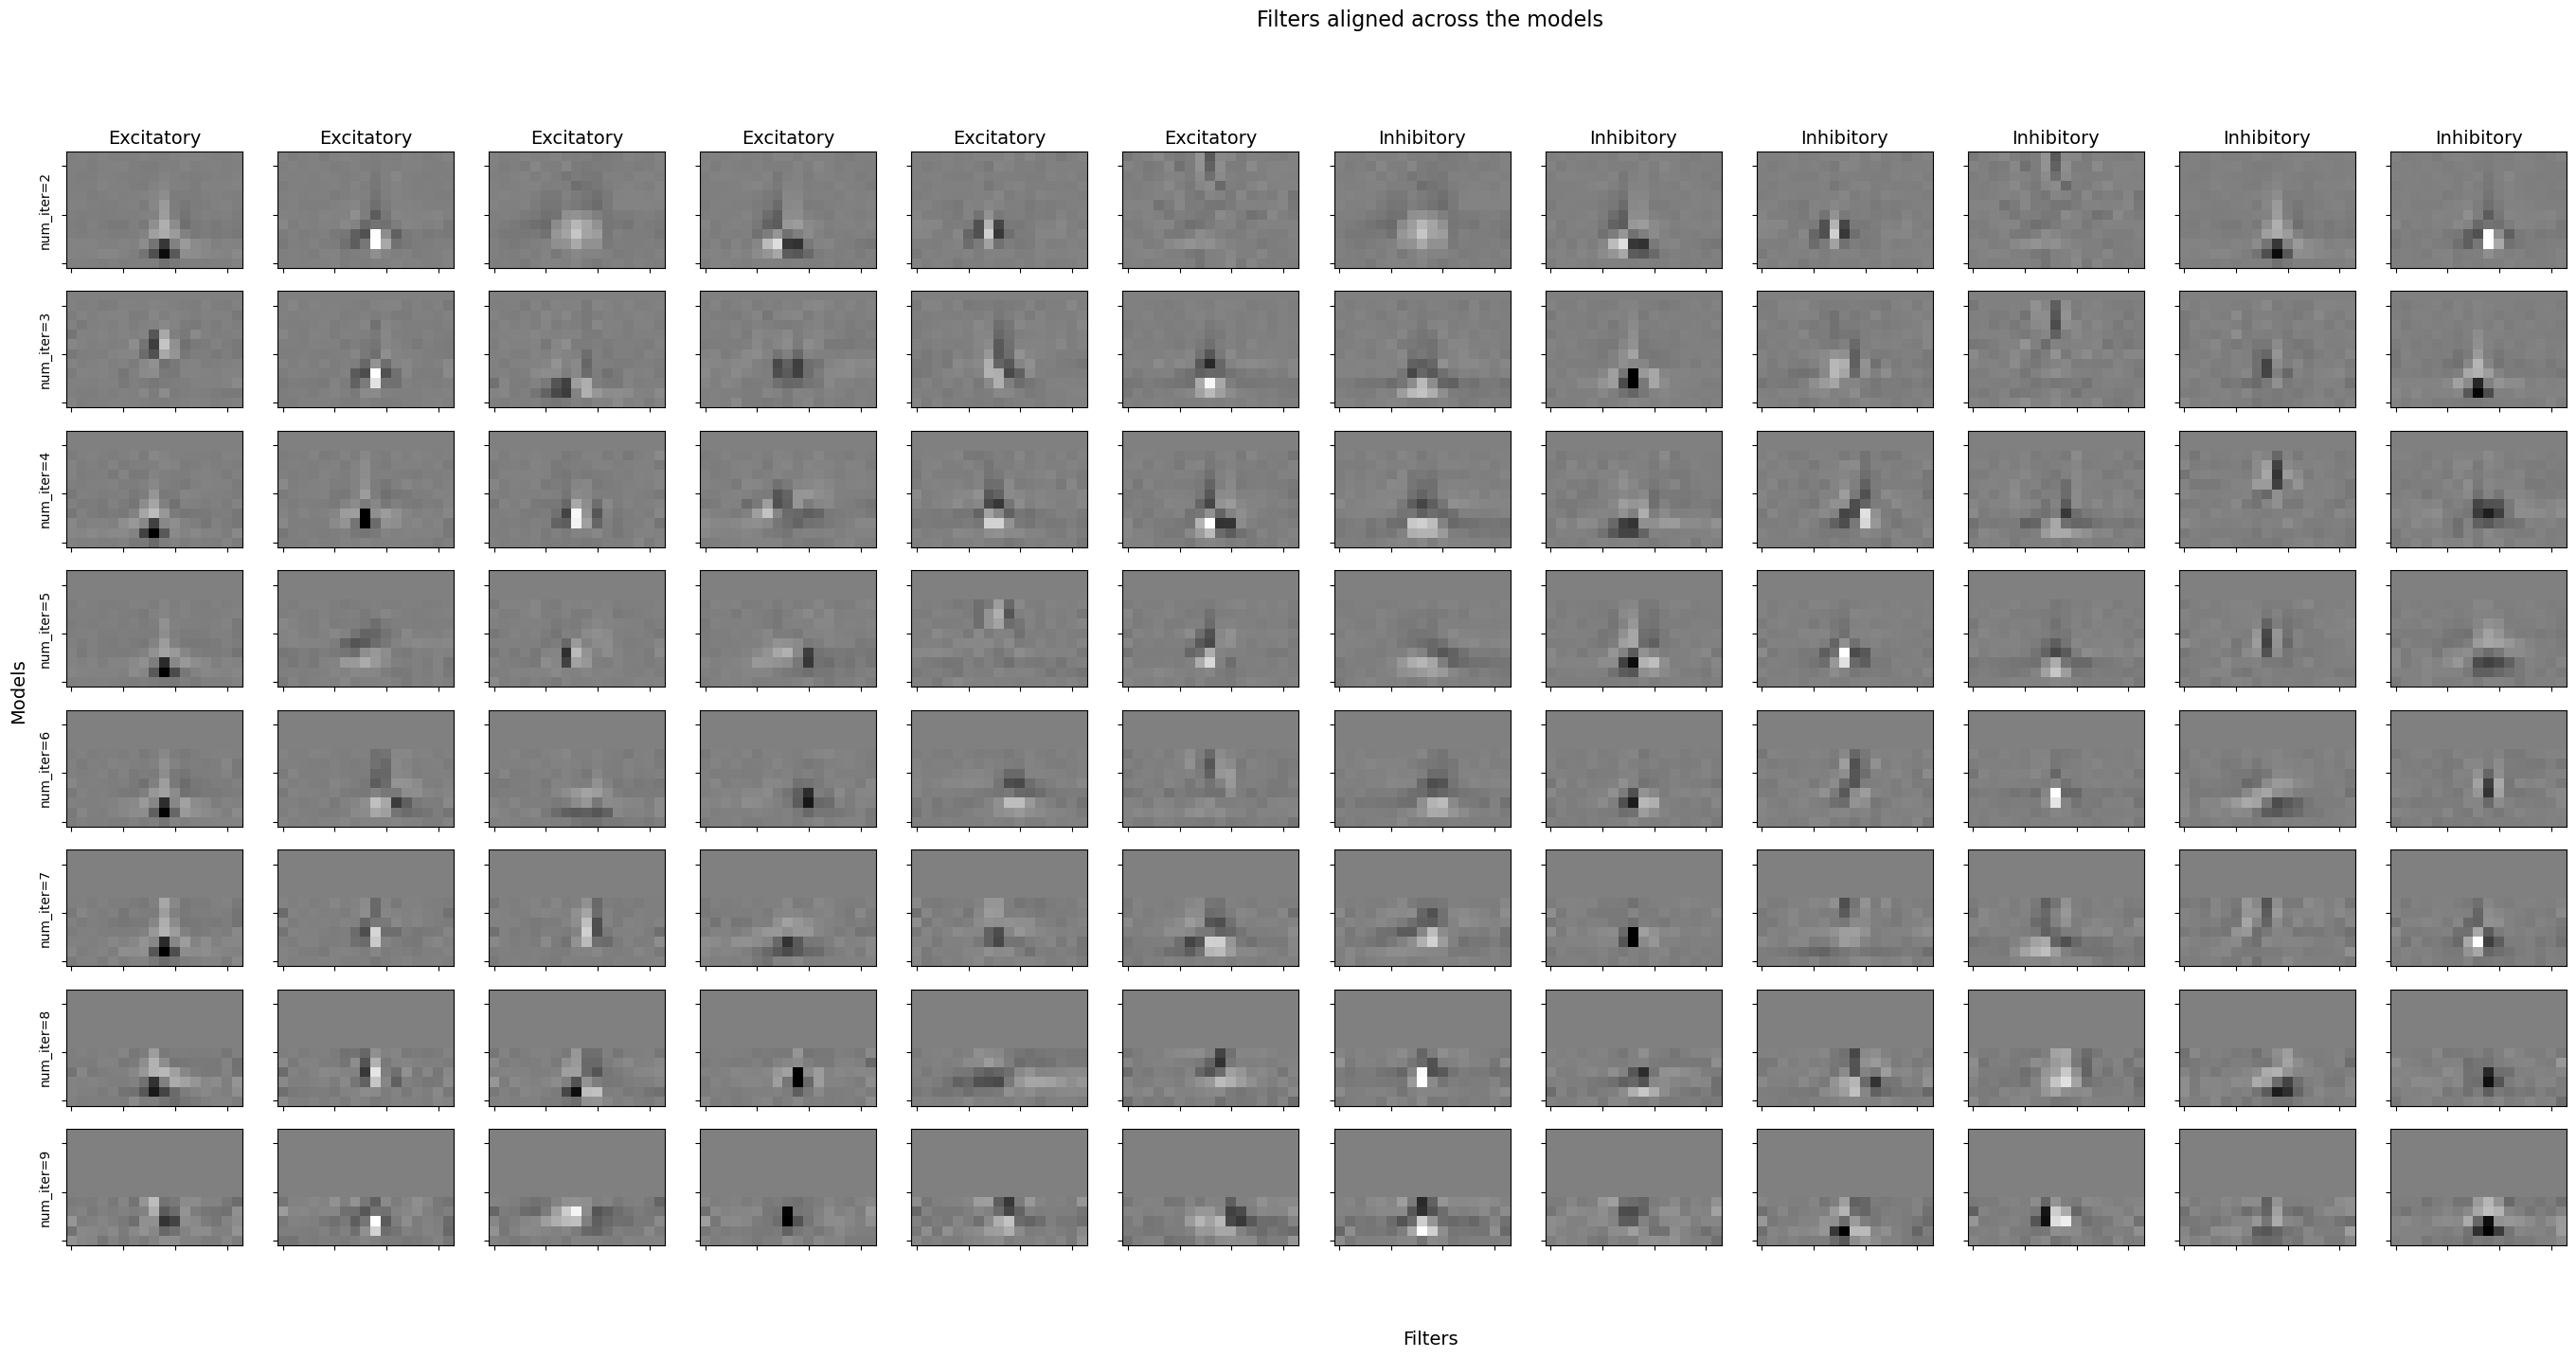

In [6]:
plot.plot_aligned_filters([trial.model for trial in best_trials], model_names=['num_iter='+str(i) for i in num_iterses], figsize=(30,15))

In [8]:
best_trials[1].model.networks[1].layers[0].weights.shape

(48, 36, 139)

In [75]:
# get the weights of the readout layer for the best models
# and just get the middle space-time filter
center_readout_weights = []
max_readout_weights = []
sum_readout_weights = []
readout_weights_by_neuron = []
for trial in best_trials:
    sum_neurons = np.sum(trial.model.networks[1].layers[0].weights[:,:,:], axis=1)
    # make inhibitory weights negative (every 12 weights need to be flipped)
    for i in range(num_inh,sum_neurons.shape[0],num_subunits):
        sum_neurons[i:i+num_inh,:] = -sum_neurons[i:i+num_inh,:]
    sum_readout_weights.append(sum_neurons)
    
    max_neurons = np.max(trial.model.networks[1].layers[0].weights[:,:,:], axis=1)
    # make inhibitory weights negative (every 12 weights need to be flipped)
    for i in range(num_inh,max_neurons.shape[0],num_subunits):
        max_neurons[i:i+num_inh,:] = -max_neurons[i:i+num_inh,:]
    max_readout_weights.append(max_neurons)
    
    center_neurons = trial.model.networks[1].layers[0].weights[:,15,:]
    # make inhibitory weights negative (every 12 weights need to be flipped)
    for i in range(num_inh,center_neurons.shape[0],num_subunits):
        center_neurons[i:i+num_inh,:] = -center_neurons[i:i+num_inh,:]
    center_readout_weights.append(center_neurons)

    neurons = []
    for neuron in range(trial.model.networks[1].layers[0].weights.shape[2]):
        weights = trial.model.networks[1].layers[0].weights[:,:,neuron]
        # make inhibitory weights negative (every 12 weights need to be flipped)
        for i in range(num_inh,weights.shape[0],num_subunits):
            weights[i:i+num_inh,:] = -weights[i:i+num_inh,:]
        neurons.append(weights)
    readout_weights_by_neuron.append(neurons)

# print a shape to make sure it's right
print(readout_weights_by_neuron[0][0].shape)
print(center_readout_weights[0].shape)
print(max_readout_weights[0].shape)
print(sum_readout_weights[0].shape)

(36, 36)
(36, 139)
(36, 139)
(36, 139)


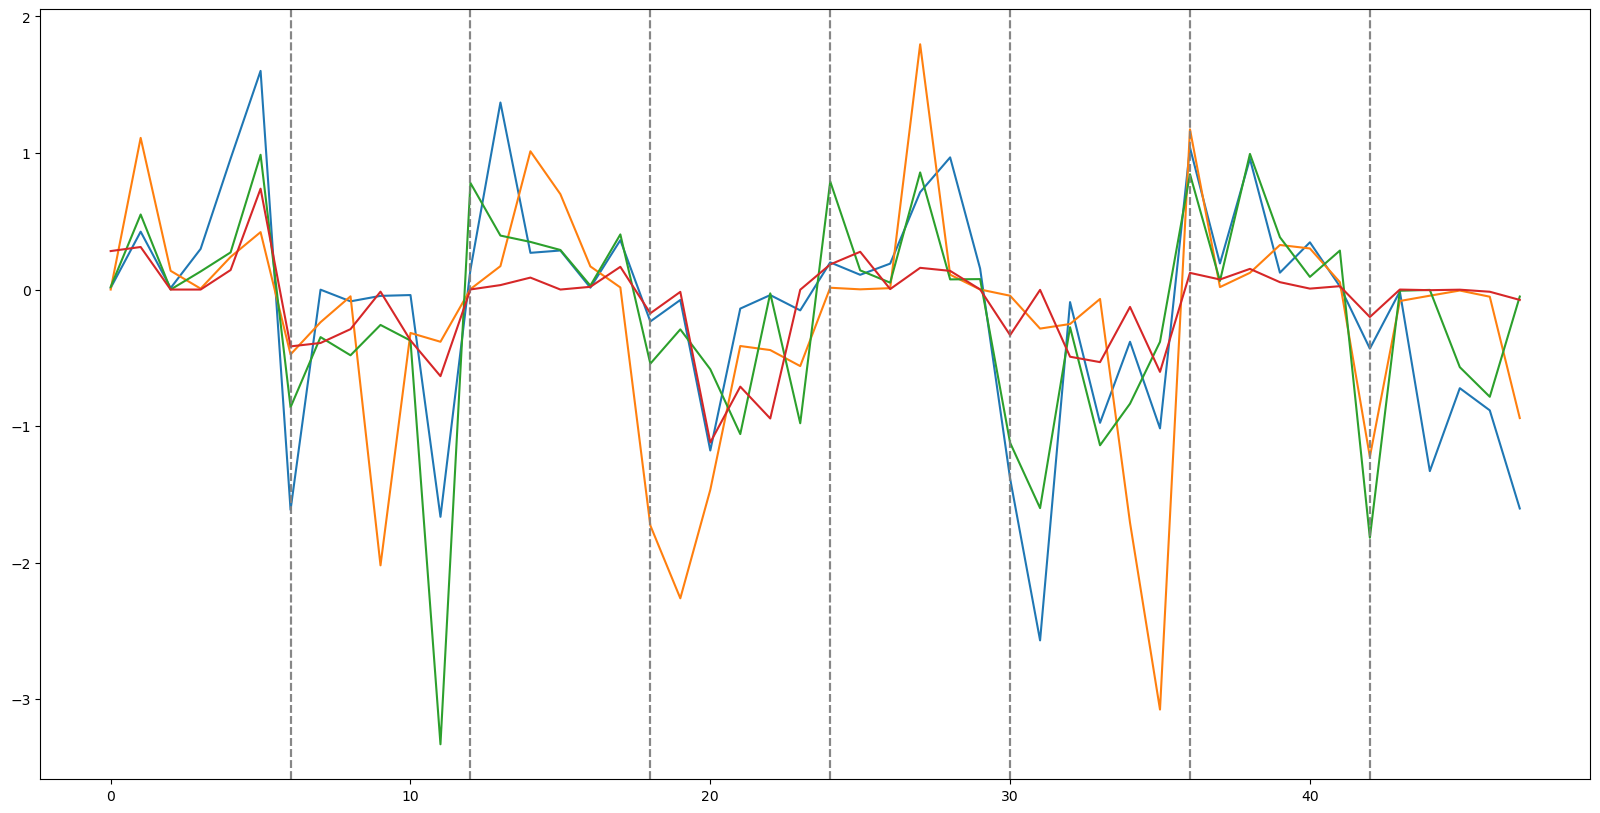

In [76]:
# plot one of the readout weights
fig = plt.figure(figsize=(20,10))
for i in range(4):
    _ = plt.plot(sum_readout_weights[1][:,i])
    # draw vertical lines every num_inh
    for j in range(num_inh, sum_readout_weights[1].shape[0], num_inh):
        _ = plt.axvline(x=j, color='gray', linestyle='--', alpha=0.5)

In [77]:
dataset.SUs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  35,  36,
        37,  38,  39,  63,  64,  65,  66,  91,  92,  93, 114, 115, 116,
       117, 118, 119, 120, 121, 122])

# plot the readout weights for each model

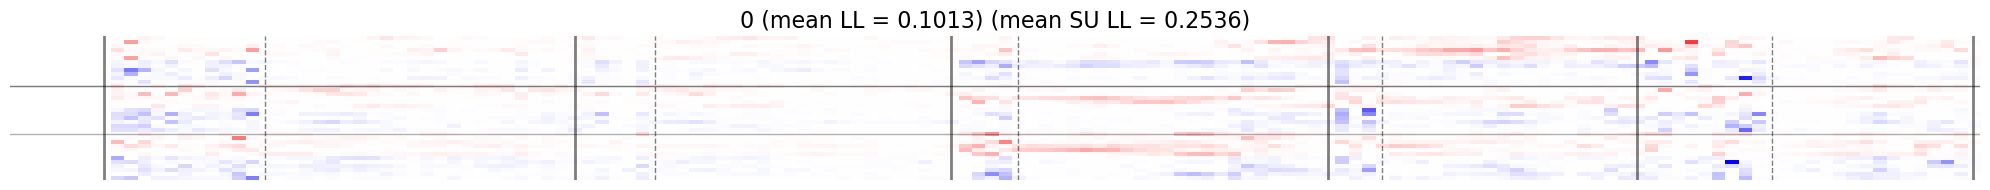

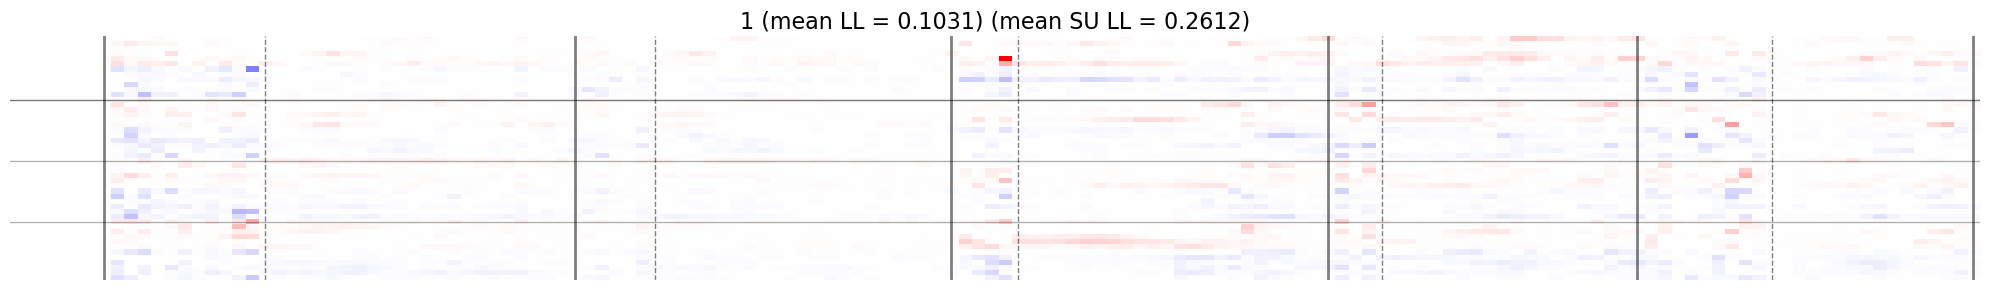

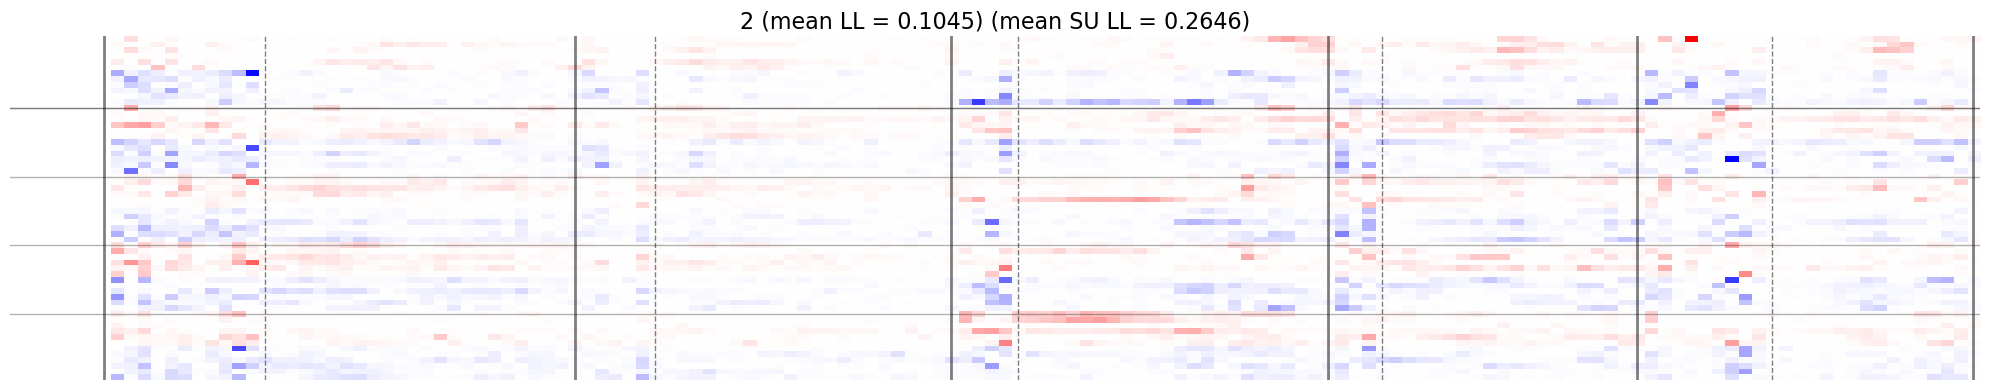

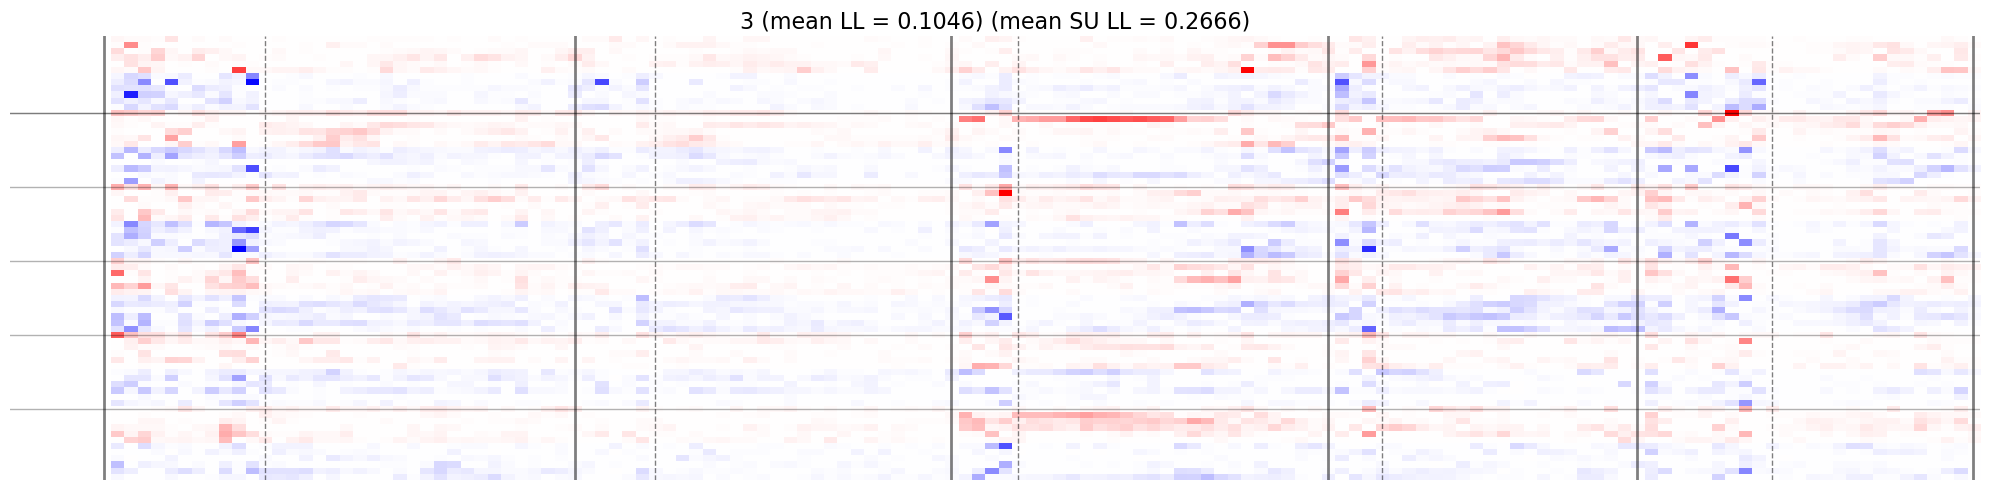

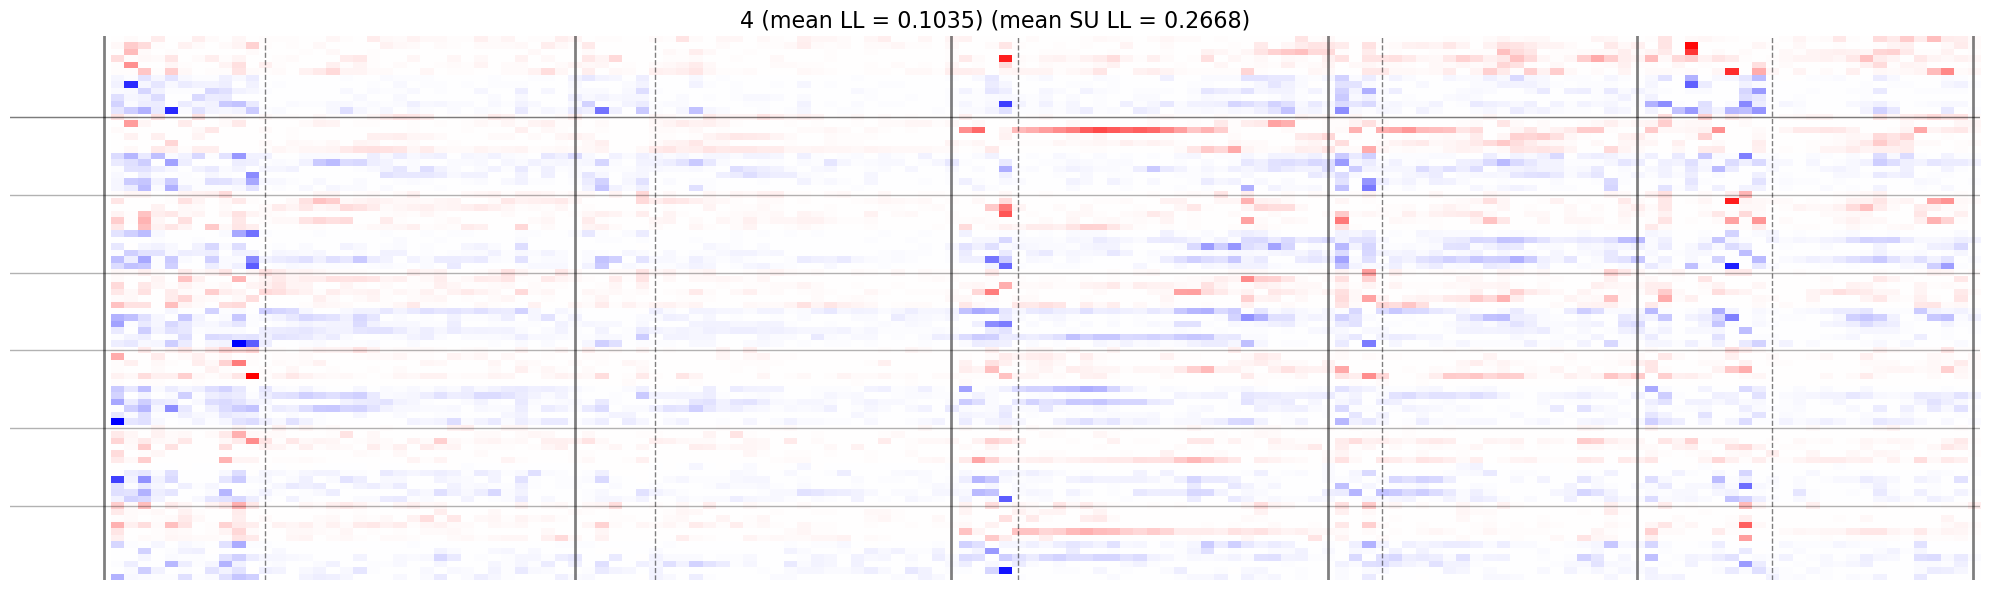

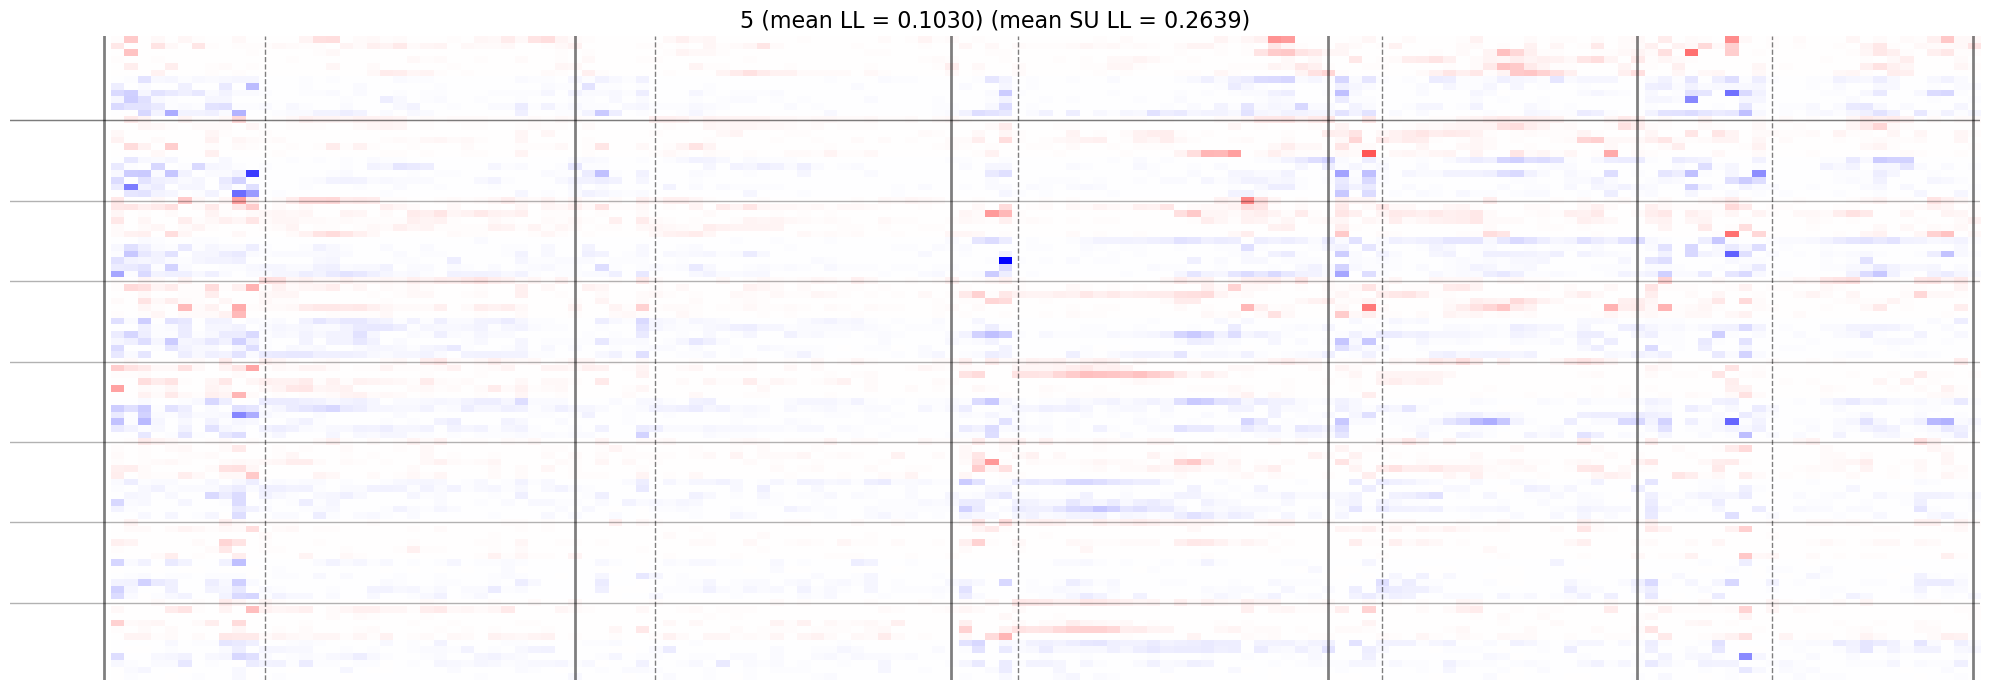

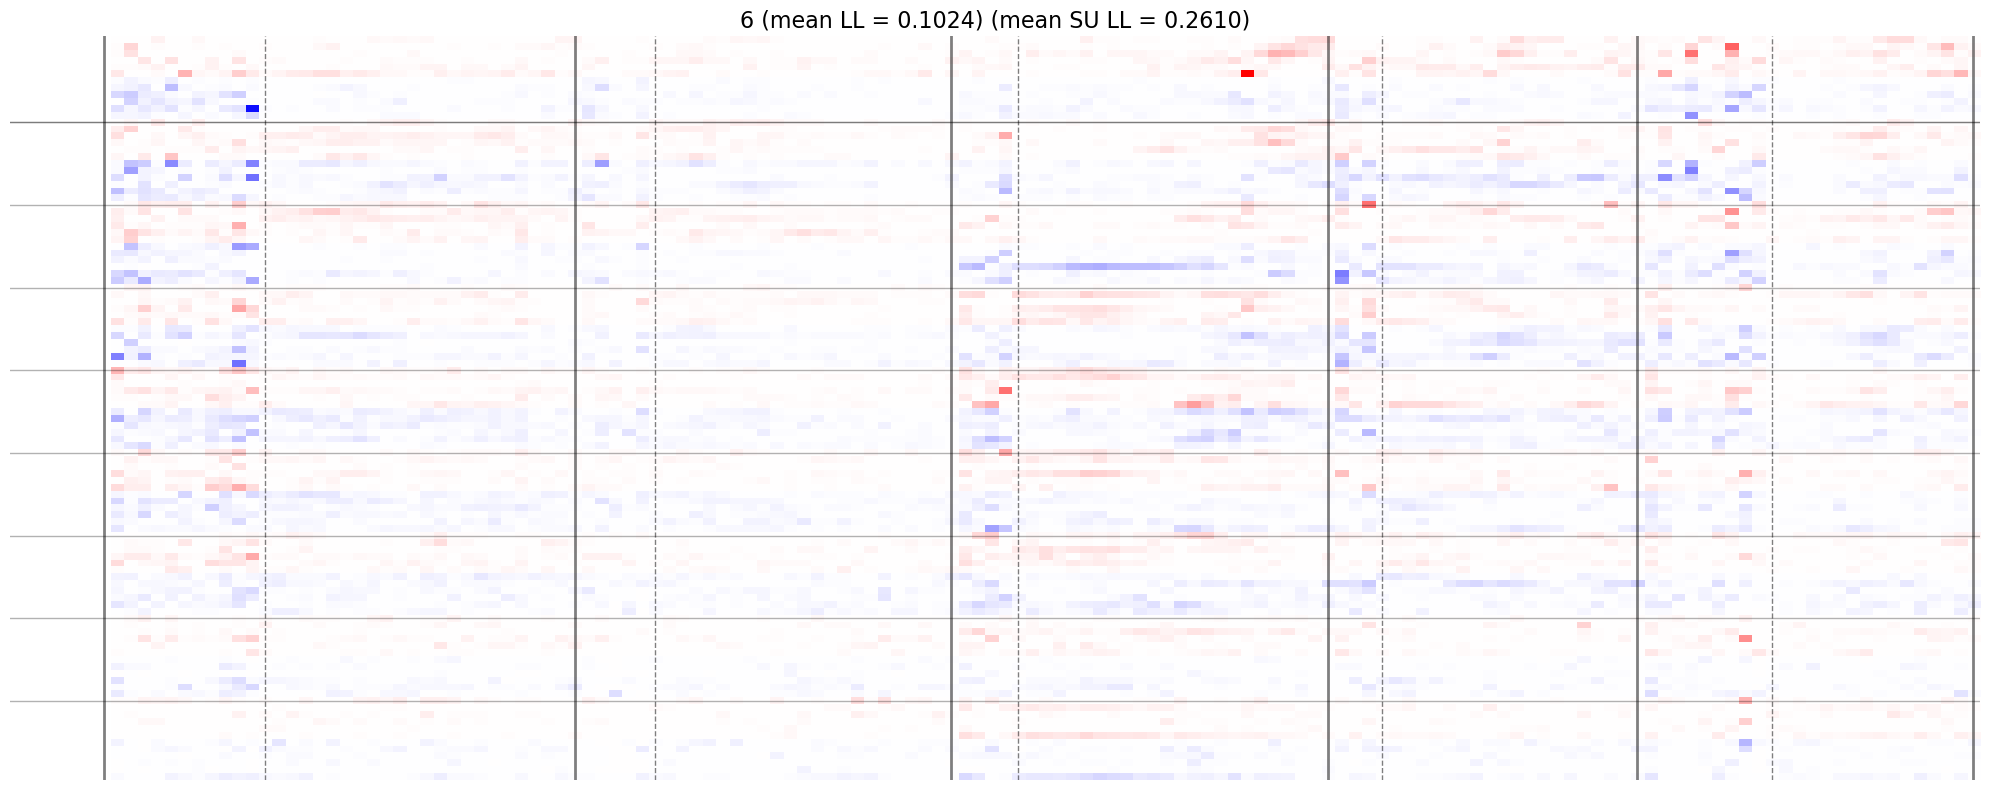

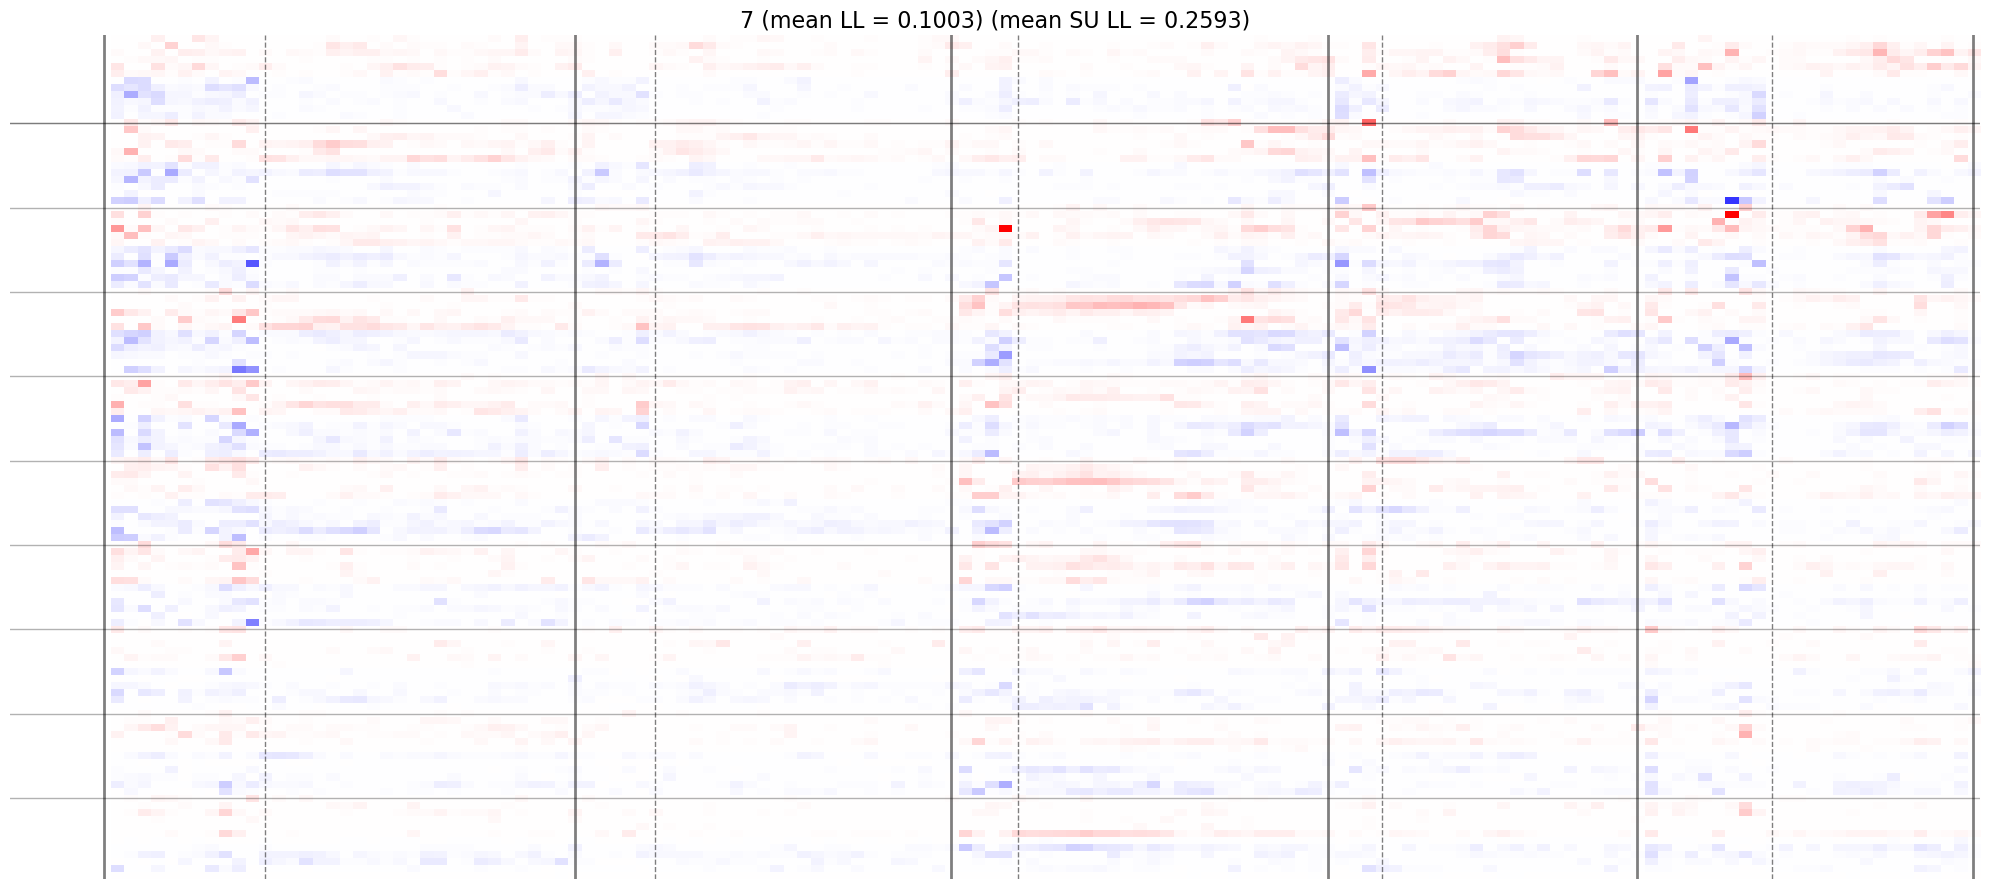

In [283]:
def plot_readout_weights(readout_weights, k, num_subunits, num_inh, num_iter, model_names=None, figsize=(20,5)):
    # get the mean LLs for just the SUs in k
    mean_SU_LLs = np.mean(best_trials[k].LLs[dataset.SUs])
    
    if model_names is None:
        model_names = [str(i) for i in range(len(readout_weights))]
    
    # get the mean LLs for k
    mean_LLs = np.mean(best_trials[k].LLs)
    
    fig = plt.figure(figsize=figsize)
    plot.imagesc(readout_weights[k], cmap='bwr', colrow=False, origin='upper')
    plt.title(model_names[k] + ' (mean LL = %.4f)' % mean_LLs + ' (mean SU LL = %.4f)' % mean_SU_LLs, fontsize=16)
    plt.axis('off')

    # put a vertical line between each experiment
    for expt_boundary in expt_boundaries:
        plt.axvline(expt_boundary-1, color='k', linewidth=2, alpha=0.5)
        
    # put a vertical line between the SUs and the MUs
    # get the indices of the SUs where the experiment boundaries are
    SU_boundaries = np.where(np.diff(dataset.SUs) > 1)[0]
    
    for SU_boundary in SU_boundaries:
        plt.axvline(dataset.SUs[SU_boundary]+1, color='k', linewidth=1, alpha=0.5, linestyle='--')
    # plot the last SU boundary
    plt.axvline(dataset.SUs[-1]+1, color='k', linewidth=1, alpha=0.5, linestyle='--')

    # put a horizontal line between each layer
    layer_boundaries = [num_subunits]
    for layer in range(1, num_iter+1):
        layer_boundaries.append(layer*int(num_subunits))
    for layer_boundary in layer_boundaries:
        plt.axhline(layer_boundary, color='k', linewidth=1, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
for k, num_iter in zip(range(len(center_readout_weights)), num_iterses):
    plot_readout_weights(sum_readout_weights, k, num_subunits=num_subunits, num_inh=num_inh, num_iter=num_iter, figsize=(20,num_iter))

# cluster the weights by neuron

In [82]:
sum_readout_weights[0].shape

(36, 139)

In [84]:
def plot_cluster_readout_weights(readout_weights, k, figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    expts = range(1, len(expt_boundaries))
    colors = ['red', 'orange', 'green', 'blue', 'black']
    print(list(zip(colors, expts)))
    # get the readout weights for the first key
    readout_weights_k = readout_weights[k].T
    
    # scale the weights
    scaled_readout_weights_k = StandardScaler().fit_transform(readout_weights_k)

    # cluster the weights
    clusterable_embedding = umap.UMAP(
        n_components=2,
        random_state=42
    ).fit_transform(scaled_readout_weights_k)

    # color by the experiment they came from
    expt_colors = np.zeros(readout_weights_k.shape[0])
    for i in range(len(expt_boundaries)-1):
        expt_colors[expt_boundaries[i]:expt_boundaries[i+1]] = i

    cmap = matplotlib.colors.ListedColormap(colors)

    # plot the clusters
    plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=30, c=expt_colors, cmap=cmap)
    plt.title(k)
    plt.show()

In [ ]:
# get its connections
# fig = plt.figure(figsize=(20,5))
# neuron_weights = best_trials[1].model.networks[1].layers[0].weights[:,:,1]
# plot.imagesc(neuron_weights.T)
# 
# # is the jacobian reshaped correctly?
# # can we reshape the first dimension into two dimensions the way I am doing it?
# print(results_3iter.jacobians[0]['core'][0].shape, results_3iter.jacobians[0]['core'][1].shape)
# l0_reshaped = np.reshape(results_3iter.jacobians[0]['core'][0].squeeze()[:432,:], (12,36,504))
# l1_reshaped = np.reshape(results_3iter.jacobians[0]['core'][1].squeeze()[:,:], (36,36,504))
# l0_l1_reshaped = np.concatenate((l0_reshaped, l1_reshaped), axis=0)
# print(l0_l1_reshaped.shape, neuron_weights.shape)
# weighted_jacobian = neuron_weights[19,:].T @ l0_l1_reshaped[19,:,:]
# print(weighted_jacobian.shape)
# 
# fig = plt.figure(figsize=(20,5))
# plt.plot(neuron_weights[19,:])
# 
# # plot the weighted jacobian
# fig = plt.figure(figsize=(20,5))
# plt.imshow(weighted_jacobian.reshape(36,14).T, cmap='gray', origin='lower')
# plt.xlabel('Time (ms)', fontsize=16)
# plt.ylabel('Weighted Jacobian', fontsize=16)
# plt.title('Neuron {}'.format(neuron), fontsize=16)
# plt.show()

# get DSTRFs

In [631]:
print(dataset.NT)

1858460


In [11]:
# look at the temporal evolution of the subunits in the iterative layers
# get the DSTRFs for each layer for the 2-iter model

# print the shape of the readout layer for the first best_model
shape = best_trials[0].model.networks_by_name['readout'].layers[0].weights.shape
print(shape[0] * shape[1], shape[2])

print(14-(3*(2-1)))

# input layer   36x14 = 504
# Tconv layer   36x12 = 432 x 4 lags = 1728
# IterT layer   36x12x3 = 1296
# readout layer 1728x139



1296 139
11
input dims [1, 36, 1, 14]
SHAPES torch.Size([500000, 1728]) torch.Size([500000, 1296]) 432 36 11 12
prev outputs torch.Size([432, 1728]) torch.Size([500000, 1296])
concatenated prev_output shape torch.Size([500000, 1728])


# look at a single neuron

In [0]:
# directionally selective neurons:
neurons = [0, 8, 91, 115, 131]

# SET PARAMETERS
timepoint = 3
neuron = 2
################

batch_size = 100000 #500000

ti = 3
spike_pred_times_neurons = {neuron: [] for neuron in neurons}
for nt in range(batch_size, dataset.NT, batch_size):
    print('### Trial', ti, 'Time', nt)
    results_3iter = predict.predict(best_trials[ti].model, dataset=dataset[nt-batch_size:nt], calc_jacobian=False, verbose=False)
    for neuron in neurons:
        print('--> Neuron', neuron)
        # find times when the neuron spikes and the prediction is above a threshold at the same time
        spike_times = np.where(dataset.robs[nt-batch_size:nt,neuron] > 0)[0]
        pred_times = np.where(results_3iter.pred[:,neuron] > 0.8)[0]
        spike_pred_times = np.intersect1d(spike_times, pred_times) - batch_size+nt
        spike_pred_times_neurons[neuron].append(spike_pred_times)
        
        print(spike_pred_times)
    print('=======')

for neuron in neurons:
    spike_pred_times_neurons[neuron] = np.concatenate(spike_pred_times_neurons[neuron])

In [56]:
# how many spikes did we predict for each neuron?
for neuron in neurons:
    print(neuron, len(spike_pred_times_neurons[neuron]))

0 7374
8 0
91 95
115 12983
131 193446


In [62]:
pred = best_trials[ti].model.NDN(dataset[spike_pred_times_neurons[115]])
pred.shape

torch.Size([12983, 139])

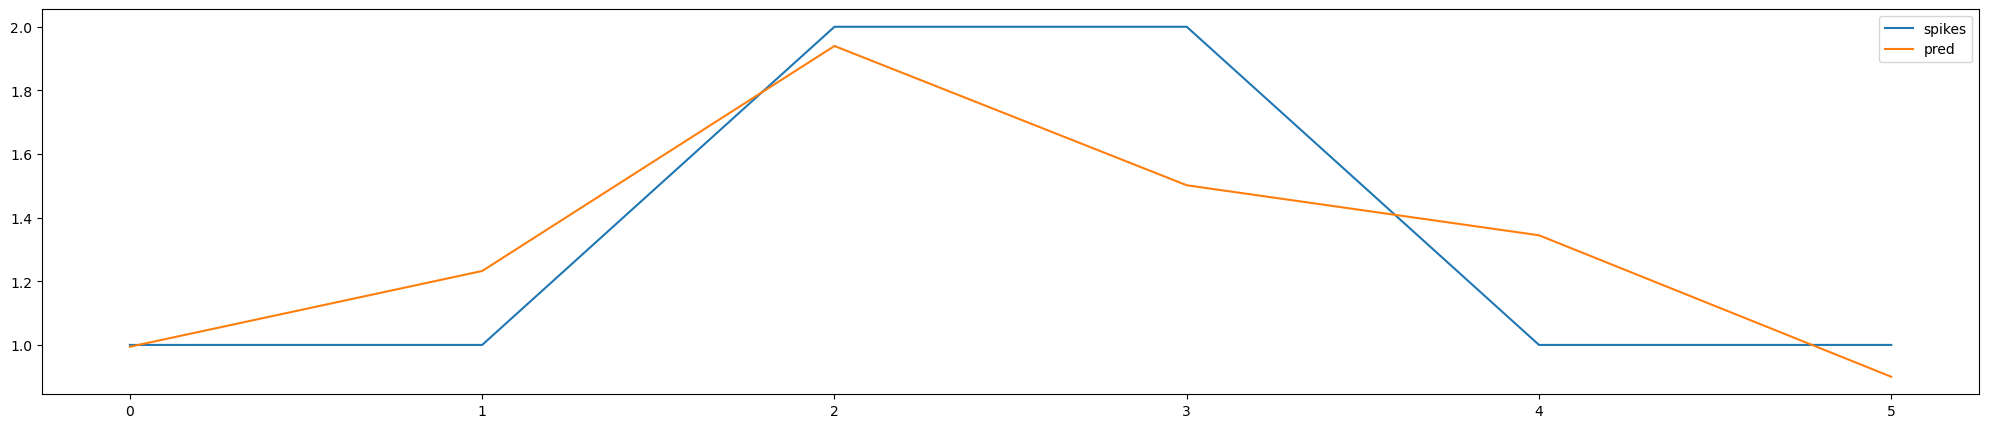

In [71]:
neuron = 115
start = 494
end = 500
fig = plt.figure(figsize=(25,5))
plt.plot(dataset.robs[spike_pred_times_neurons[115][start:end], neuron], label='spikes')
plt.plot(pred[start:end, neuron].detach().numpy(), label='pred')
plt.legend()
plt.show()

In [72]:
results_3iter = predict.predict(best_trials[ti].model, dataset=dataset[spike_pred_times_neurons[115][start:end]], calc_jacobian=True, verbose=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.93it/s]


torch.Size([2592, 504])
torch.Size([2160, 504])
torch.Size([139, 504])
(72, 36, 504) (72, 36)
(17, 11, 12)


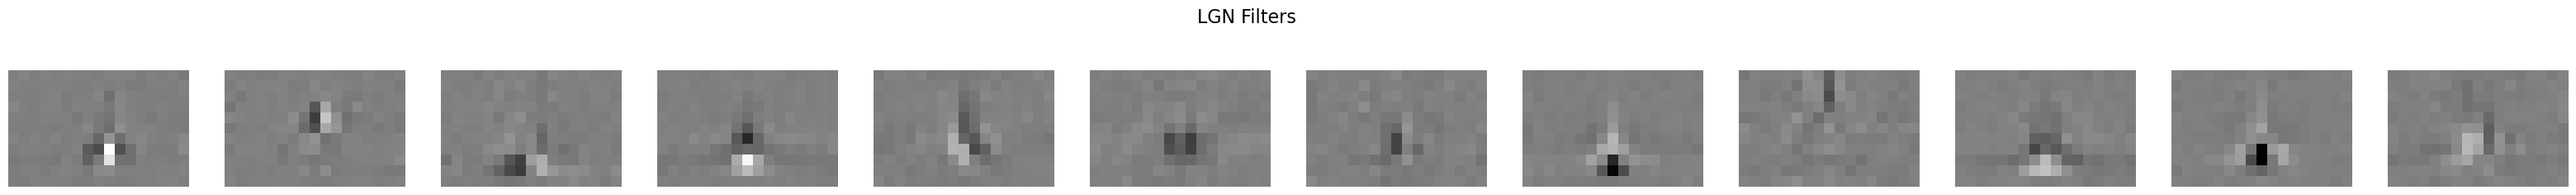

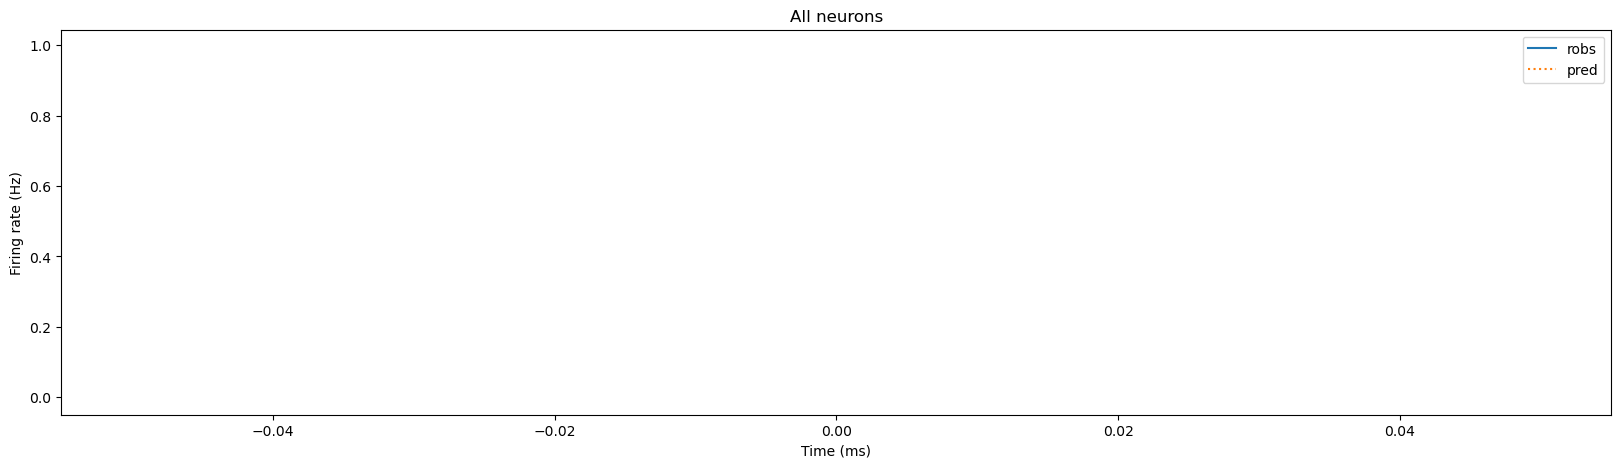

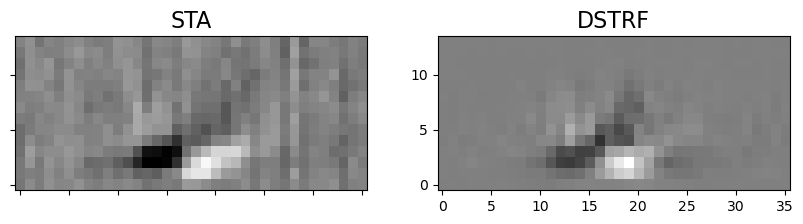

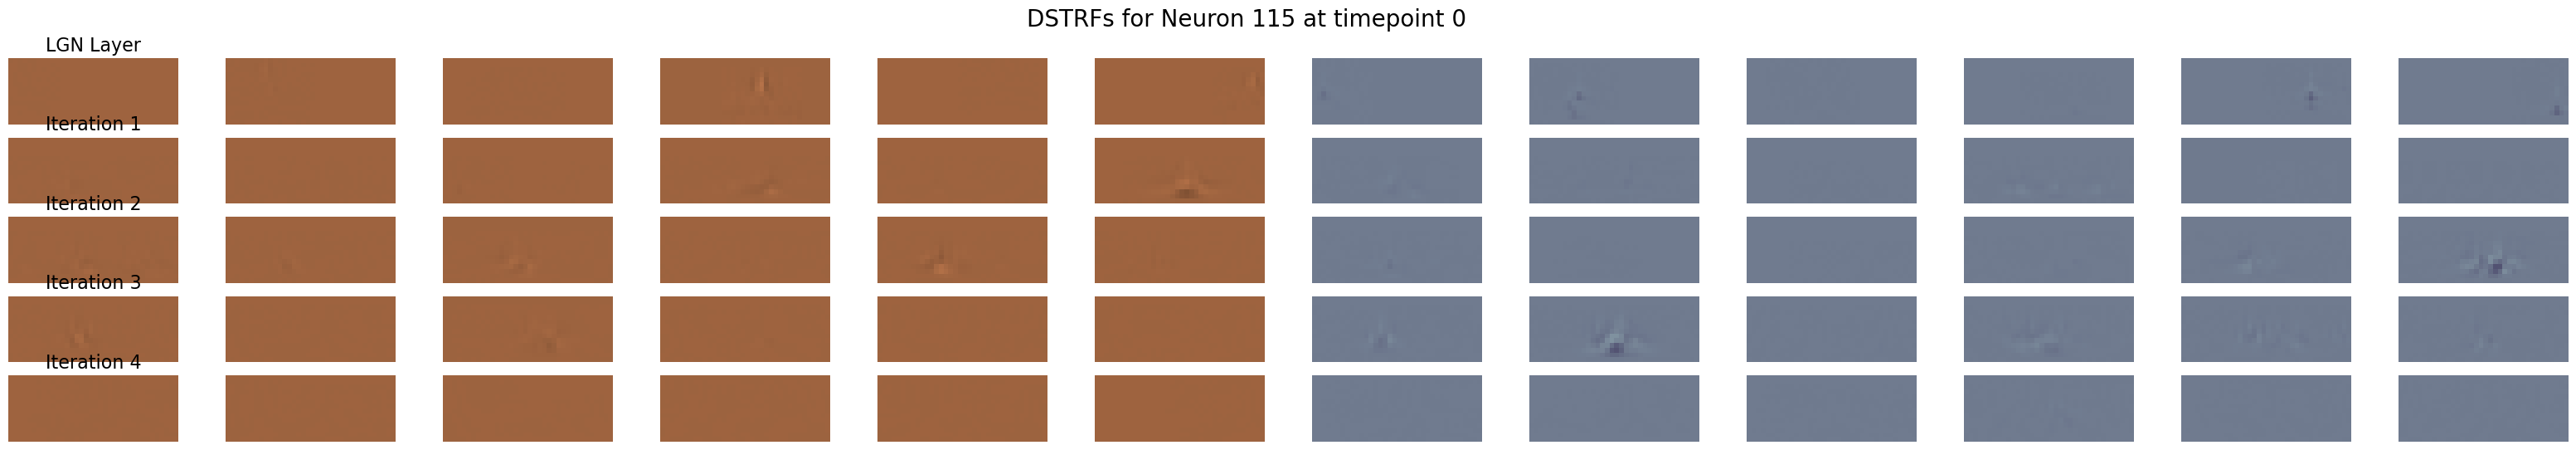

In [74]:
neuron = 115
timepoint = 0

filter_max = np.max(best_trials[1].model.networks[0].layers[0].weights)
filter_min = -filter_max

fig = plt.figure(figsize=(40,3))
for i in range(12):
    plt.subplot(1,12,i+1)
    # plot the weights for the first layer
    plt.imshow(best_trials[1].model.networks[0].layers[0].weights[:,:,i].T, cmap='gray', origin='lower', vmin=filter_min, vmax=filter_max)
    plt.axis('off')
plt.suptitle('LGN Filters', fontsize=16)

neuron_weights = best_trials[ti].model.networks[1].layers[0].weights[:,:,neuron]

# get the DSTRFs for the layers at timepoint
print(results_3iter.jacobians[timepoint]['core'][0].squeeze()[:,:].shape)
print(results_3iter.jacobians[timepoint]['core'][1].squeeze()[:,:].shape)
print(results_3iter.jacobians[timepoint]['readout'][0].squeeze()[:,:].shape)

l0_reshaped = results_3iter.jacobians[timepoint]['core'][0].squeeze()[:432,:].reshape(12,36,504)
l1_reshaped = results_3iter.jacobians[timepoint]['core'][1].squeeze()[:,:].reshape(12*(ti+2),36,504)
l2_reshaped = results_3iter.jacobians[timepoint]['readout'][0].squeeze()

# stack l0_reshaped and l1_reshaped along the middle dimension
l0_l1_reshaped = np.concatenate((l0_reshaped, l1_reshaped), axis=0)
print(l0_l1_reshaped.shape, neuron_weights.shape)

print(best_trials[1].model.networks[0].layers[0].weights.shape)

# plot the robs and preds for this neuron
plot.plot_robs(dataset.robs[timepoint,neuron], pred=results_3iter.pred[timepoint,neuron], figsize=(20,5))

# Calculate STA
num_lags = 14
Reff = dataset.robs * dataset.dfs
nspks = torch.sum(Reff, axis=0)
stas = (dataset.stim.T@dataset.robs / nspks).reshape([-1, num_lags, dataset.NC]).detach().numpy()

# plot DSTRF for the neuron 1
fig = plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plot.imagesc(stas[:, :, neuron], aspect='auto', cmap='gray_r', colrow=True, axis_labels=False)
plt.title('STA', fontsize=16)
plt.subplot(1,2,2)
plot.imagesc(results_3iter.jacobian[timepoint,0,neuron,:].reshape(36,14), cmap='gray_r', origin='lower')
plt.title('DSTRF', fontsize=16)

# plot the DSTRFs that correspond to the top subunits
# get all of the subunits linked to this neuron, and label by weight and inhibitory/excitatory

imax = np.max(l0_l1_reshaped)
imin = -imax

# normalize the neuron weights
normalized_neuron_weights = neuron_weights / np.max(neuron_weights)

fig = plt.figure(figsize=(40,6))
for i in range(12*(ti+2)):
    plt.subplot(ti+2,12,i+1)
    # if neuron weight is too small, plot a blank image
    # if np.abs(weight) < 0.1:
    #     plt.imshow(np.zeros((36,14)).T, cmap='gray', origin='lower', vmin=imin, vmax=imax)
    #     plt.axis('off')
    #     continue

    if i/12 - i//12 >= 0.5:
        cmap = 'bone'
    else:
        cmap = 'copper'

    # get a weighted sum of the l0_l1_reshaped and the neuron_weights at this neuron
    
    weighted_jacobian = neuron_weights[i,:].T @ l0_l1_reshaped[i,:,:]
    
    
    plt.imshow(weighted_jacobian.reshape(36,14).T, cmap=cmap, origin='lower', vmin=imin, vmax=imax)
    plt.axis('off')
    
    # label each row with the layer it is in
    if i/12 == 0:
        plt.title('LGN Layer', fontsize=16)
    elif i/12 == 1:
        plt.title('Iteration 1', fontsize=16)
    elif i/12 == 2:
        plt.title('Iteration 2', fontsize=16)
    elif i/12 == 3:
        plt.title('Iteration 3', fontsize=16)
    elif i/12 == 4:
        plt.title('Iteration 4', fontsize=16)
    elif i/12 == 5:
        plt.title('Iteration 5', fontsize=16)

_ = plt.suptitle('DSTRFs for Neuron {}'.format(neuron) + ' at timepoint {}'.format(timepoint), fontsize=20)
    
    # if i/12 - i//12 >= 0.5:
    #     # inhibitory
    #     plt.title('Unit {} '.format(i) + '[{:.2f}]'.format(weight), fontsize=12, color=(0,0,weight))
    # else:
    #     # excitatory
    #     plt.title('Unit {} '.format(i) + '[{:.2f}]'.format(weight), fontsize=12, color=(weight,0,0))

In [ ]:
# the filters get wider over time
# the filters move around in space over time

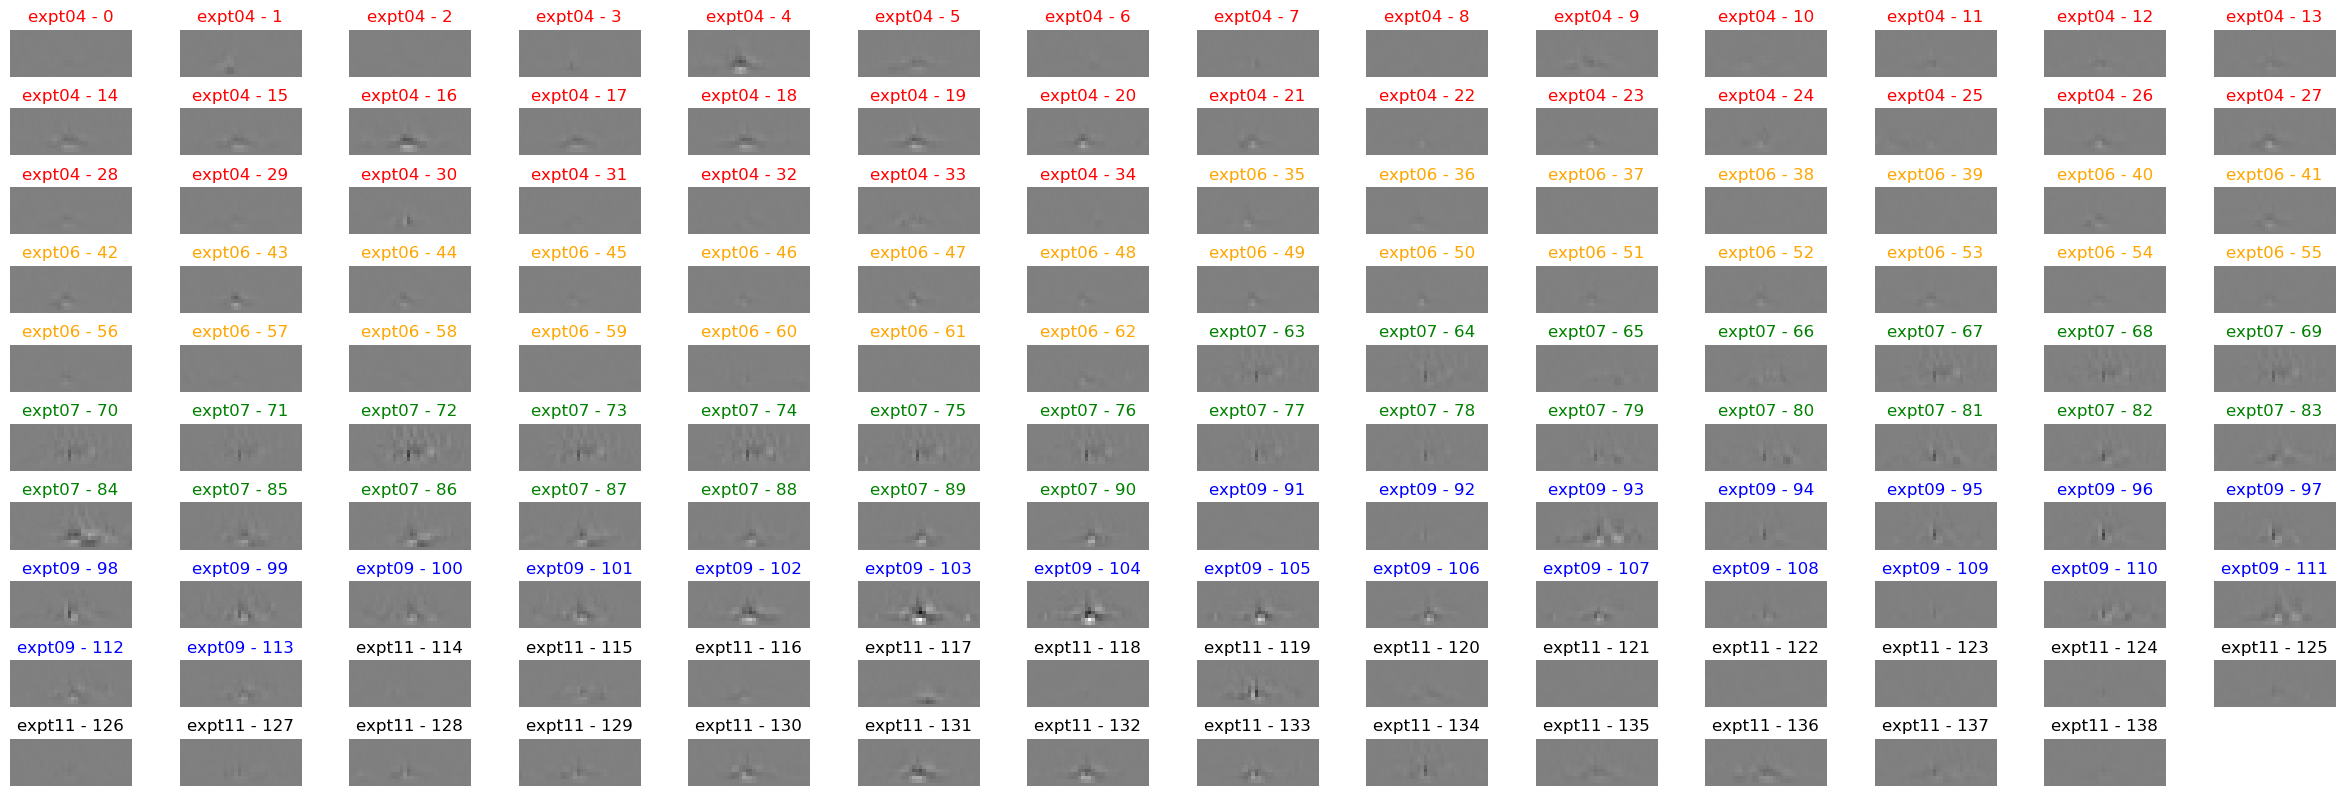

In [310]:
colors = ['red', 'orange', 'green', 'blue', 'black']
neurons = 139
rows,cols = (10,14)
max = np.max(np.abs(results_2iter.jacobian[0,0,:,:]))
fig = plt.figure(figsize=(30,10))
# make a 14x10 gridspec
grid = plt.GridSpec(rows,cols, wspace=0.4, hspace=0.3)
for n in range(neurons):
    # get the row and col
    row,col = np.unravel_index(n, (rows,cols))
    # plot the DSTRF
    plt.subplot(grid[row,col])
    plt.imshow(results_2iter.jacobian[0,0,n,:].reshape(36,14).T, cmap='gray', origin='lower', vmin=-max, vmax=max)
    plt.axis('off')
    
    # get the experiment by the n
    expti = np.where(np.array(expt_boundaries) > n)[0][0] - 1
    
    # label each neuron by its experiment
    # color the title by the experiment
    plt.title(expts[expti]+' - '+str(n), color=colors[expti])
    
plt.show()

# link DSTRF for a neuron to its connections to subunits in layers

In [ ]:
import tqdm

spike_times = []
for neuron in range(139):
    spike_times.append(len(np.where(dataset.robs[:,neuron] > 0)[0]))
plt.hist(spike_times, bins=100)
plt.show()

# calculate and populate the Jacobian for the entire model
inps = dataset['stim']
jacobians = []
def model_stim(x):
    with torch.cuda.amp.autocast():
        return best_trials[1].model.NDN({'stim': x})
for i in tqdm.tqdm(range(len(inps))): # for each input
    jacobians.append(torch.autograd.functional.jacobian(model_stim, inps[i], vectorize=True).cpu())
jacobians = torch.stack(jacobians).detach().numpy()

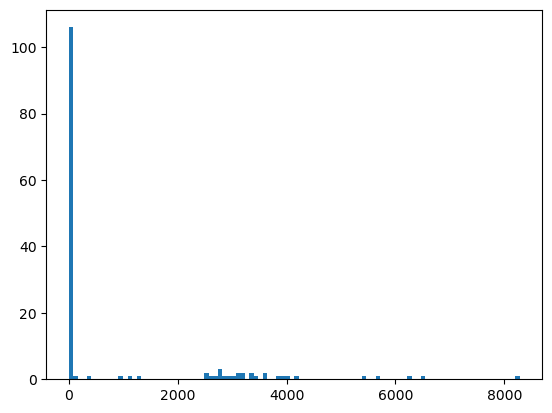

(28, 2000, 504)


In [270]:
# find the DSTRFs at each neuron when it spikes
# find the subunits+layers that each neuron projects to (above a certain weight threshold)
# look for a pattern in the DSTRFs of the neurons that project to the same layer

spike_times_lens = []
for neuron in range(139):
    spike_times_lens.append(len(np.where(dataset.robs[:10000,neuron] > 0)[0]))
plt.hist(spike_times_lens, bins=100)
plt.show()

# choose the top N neurons that have the most spikes
# get the robs where there is a spike for the neuron
spike_jacobians_neurons = []
for neuron in range(139):
    spike_times = np.where(dataset.robs[:10000,neuron] > 0)[0]
    if len(spike_times) < 2000:
        continue
    spike_jacobians = results_2iter.jacobian[spike_times[:2000],0,neuron,:]
    spike_jacobians_neurons.append(spike_jacobians)
spike_jacobians_neurons = np.array(spike_jacobians_neurons)
print(spike_jacobians_neurons.shape)

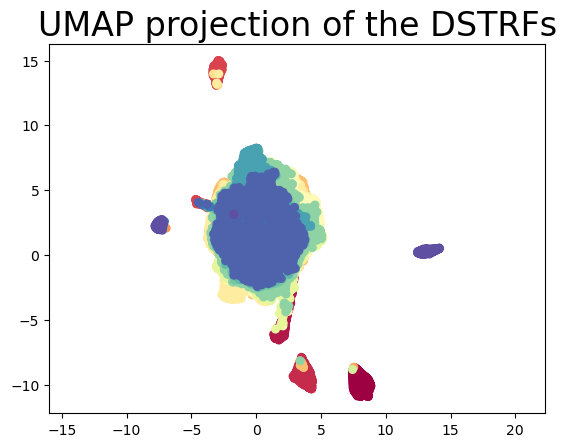

In [275]:
# cluster the neurons by their DSTRFs
jacobians = np.zeros((28*2000, 504))
neuron_colors = []
for i in range(28):
    jacobians[i*2000:(i+1)*2000,:] = spike_jacobians_neurons[i,:,:]
    # assign every 2000 jacobians to a different color
    neuron_colors.extend([i]*2000)

# cluster using UMAP
clusterable_embedding = umap.UMAP(n_components=2).fit_transform(jacobians)

# plot the clusters
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=30, c=neuron_colors, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the DSTRFs', fontsize=24)
plt.show()

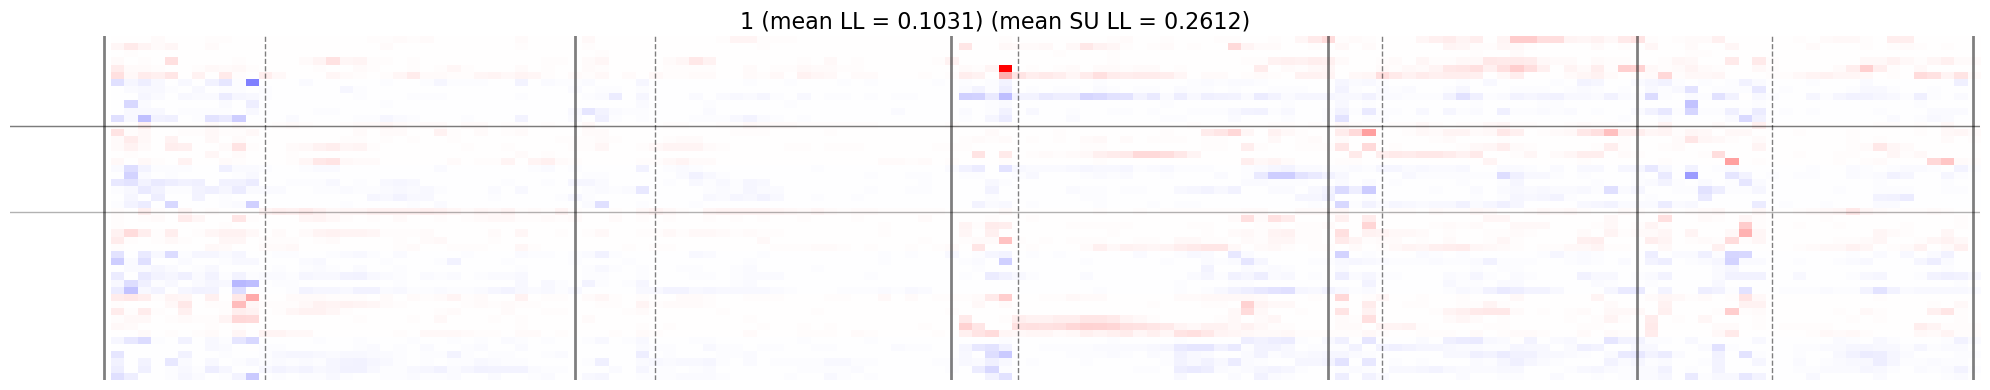

In [286]:
plot_readout_weights(sum_readout_weights, 1, num_subunits=num_subunits, num_inh=num_inh, num_iter=2, figsize=(20,4))

In [0]:
# look at a single neuron's connections over time,
# see how the DSTRFs of the subunits change based on how much information they are getting from the stimulus at that time lag
# can we interpret the subunits as representing different features of the stimulus?


In [ ]:
# then, look at the DSTRFs for the layers that each neuron projects to
#       to understand what those subunits are doing and how they define the neuron's DSTRF

In [ ]:
# get experiment boundaries (they all use the same dataset)
dataset = best_trials[0].dataset
expt_boundaries = np.concatenate([[0], np.cumsum(dataset.num_units)])
expt_boundaries

# plot STAs

(36, 14, 139)


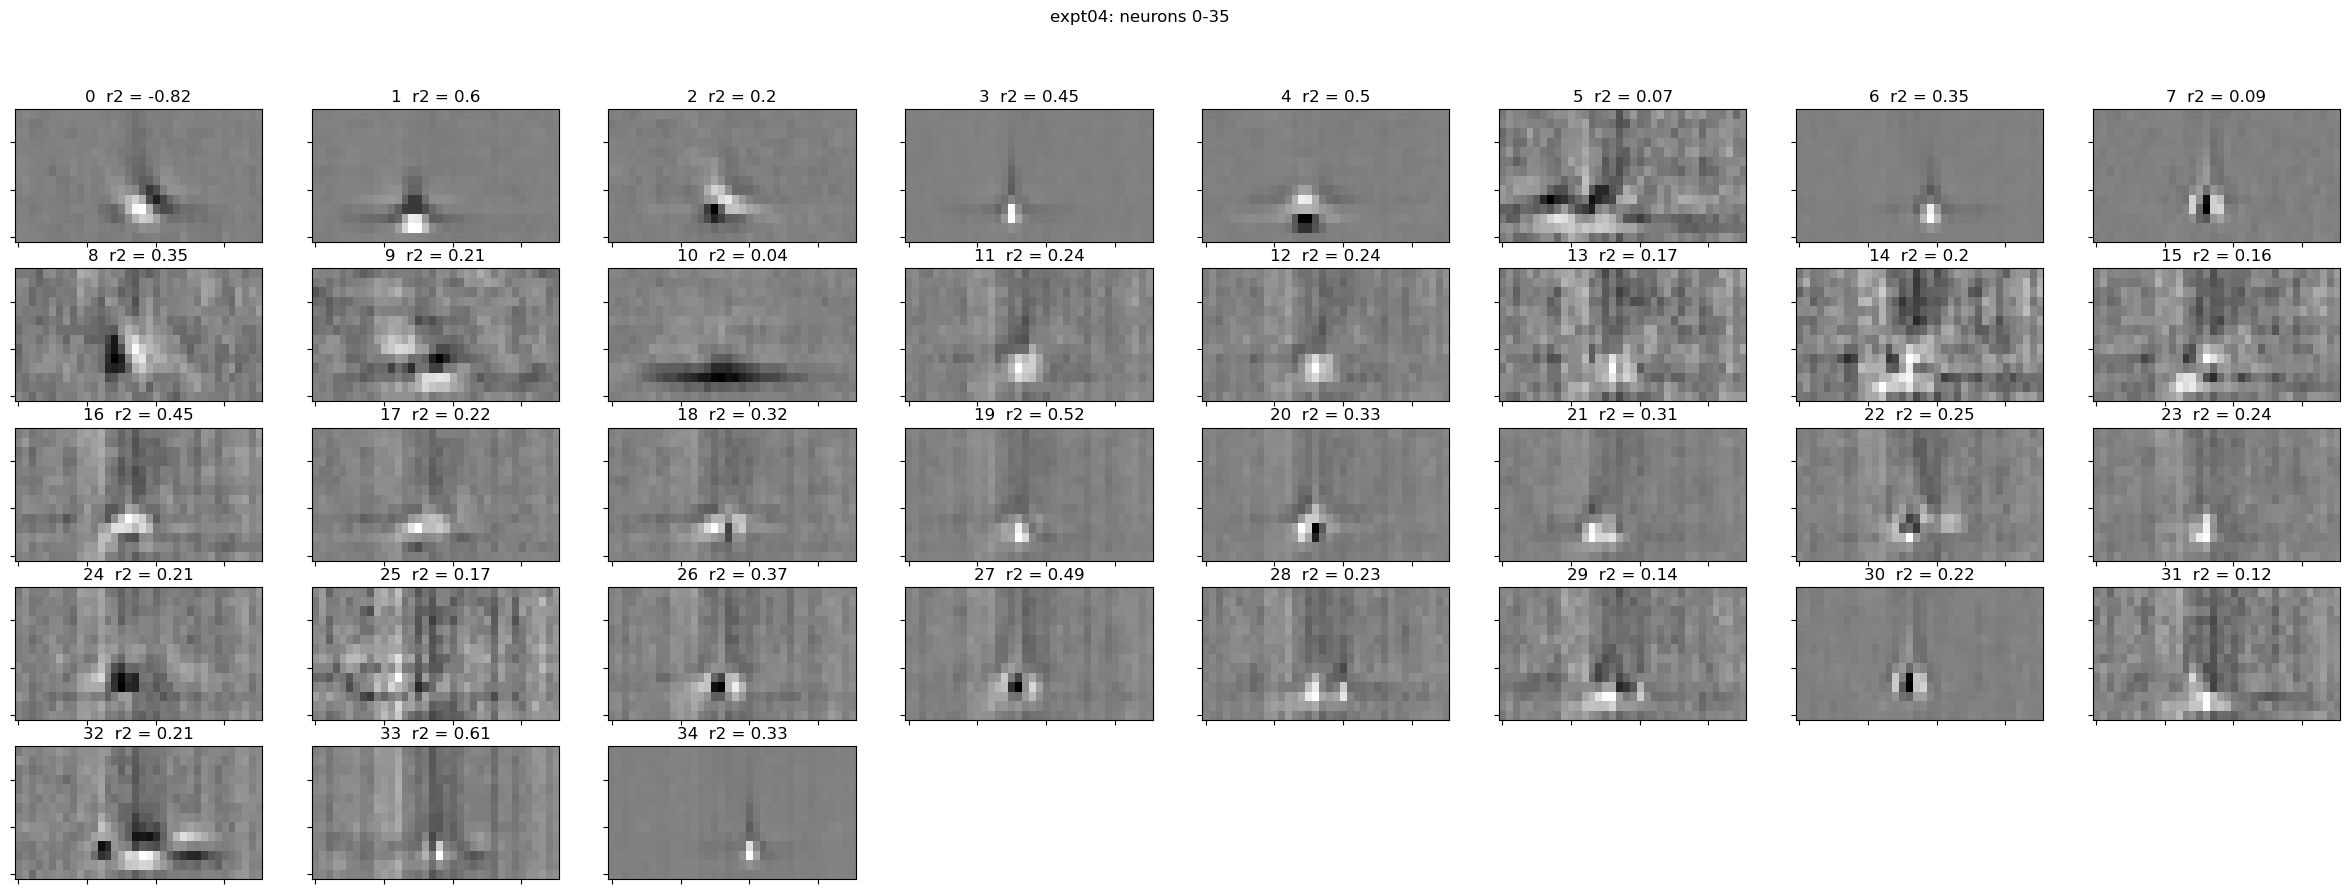

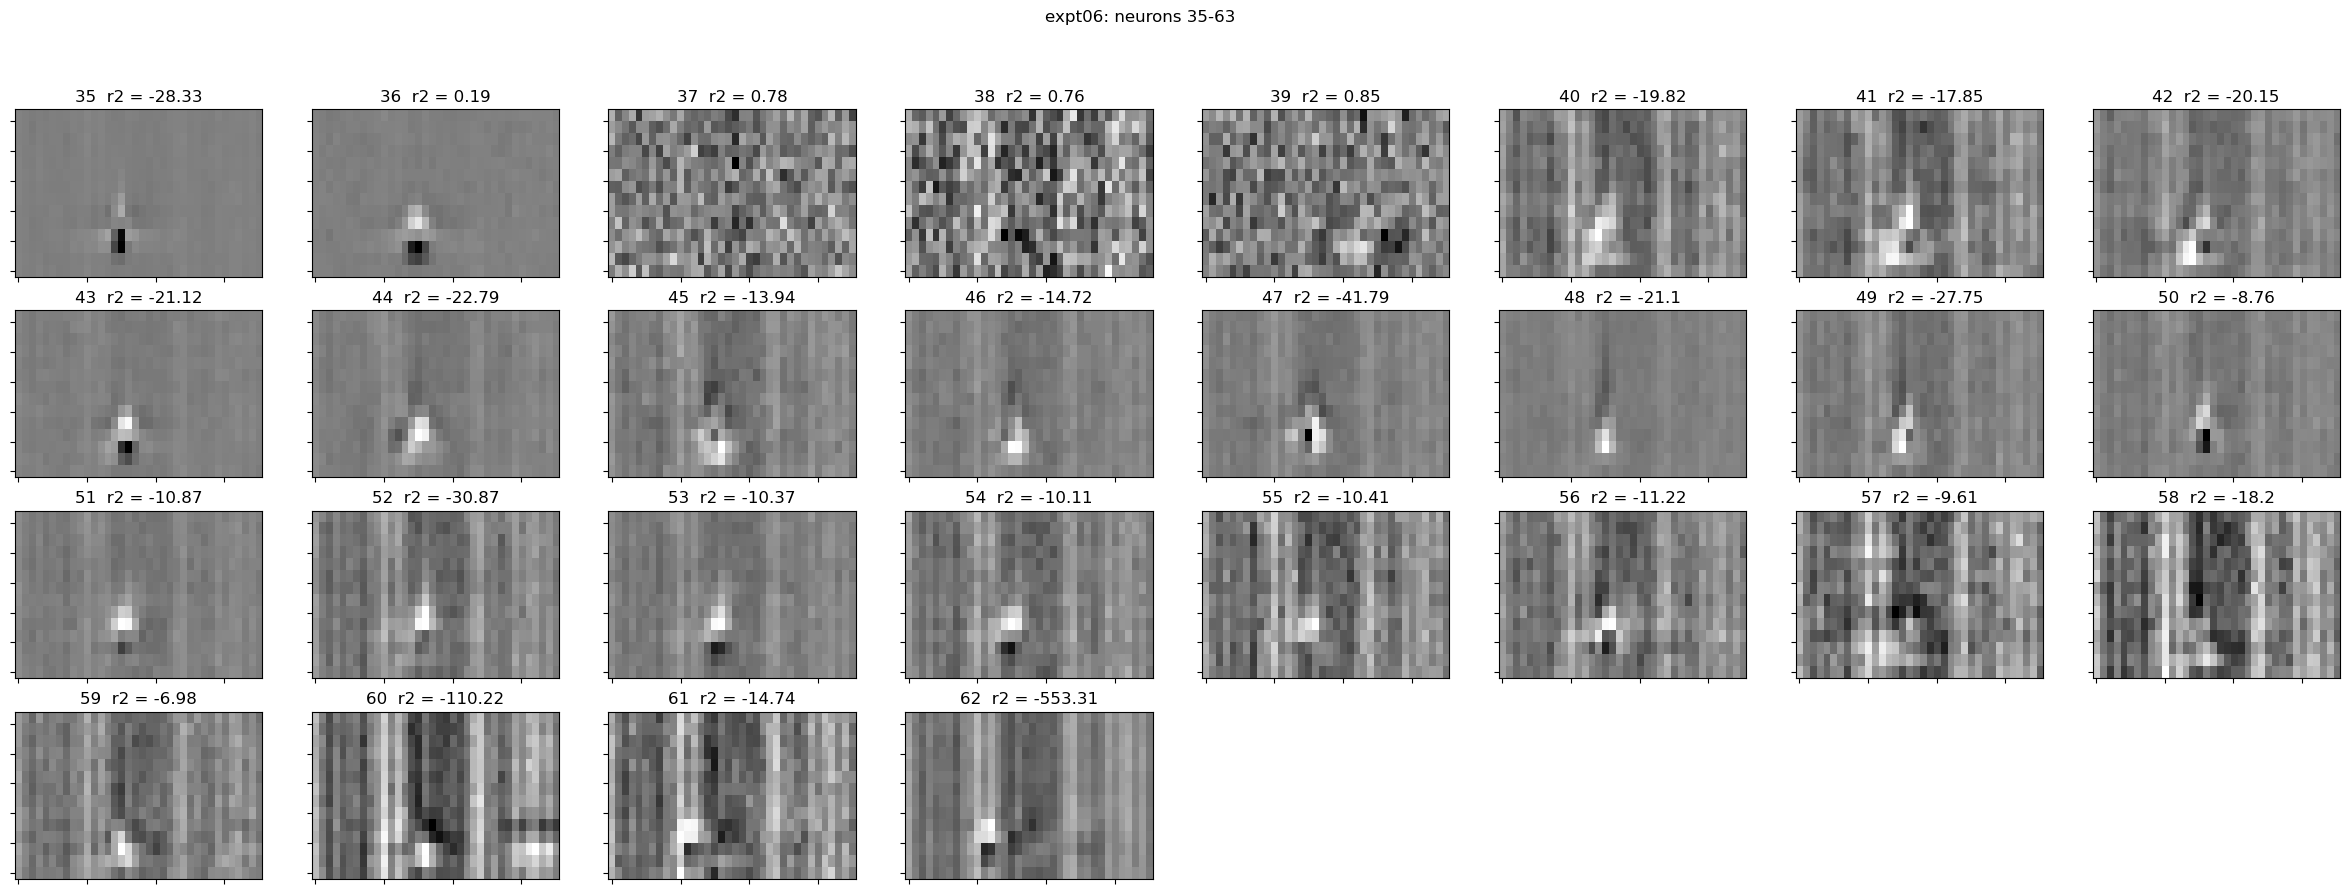

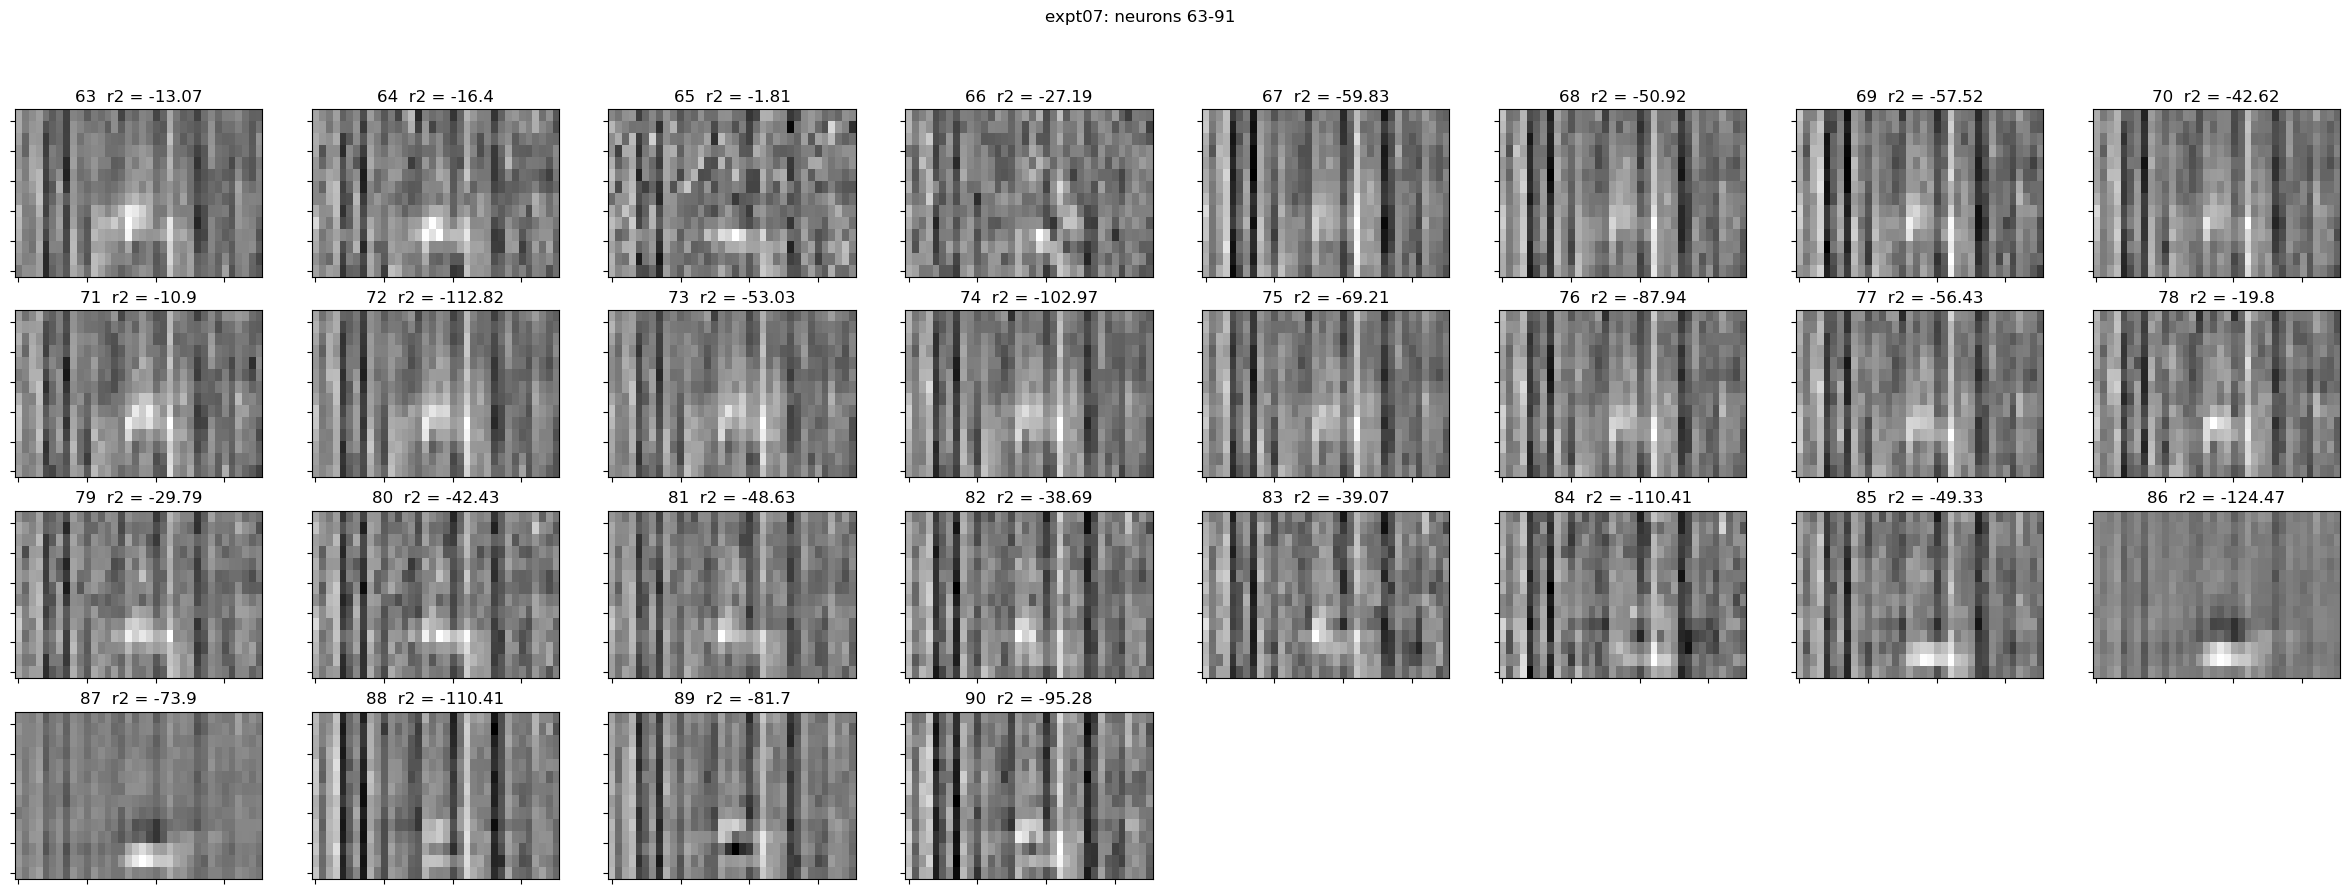

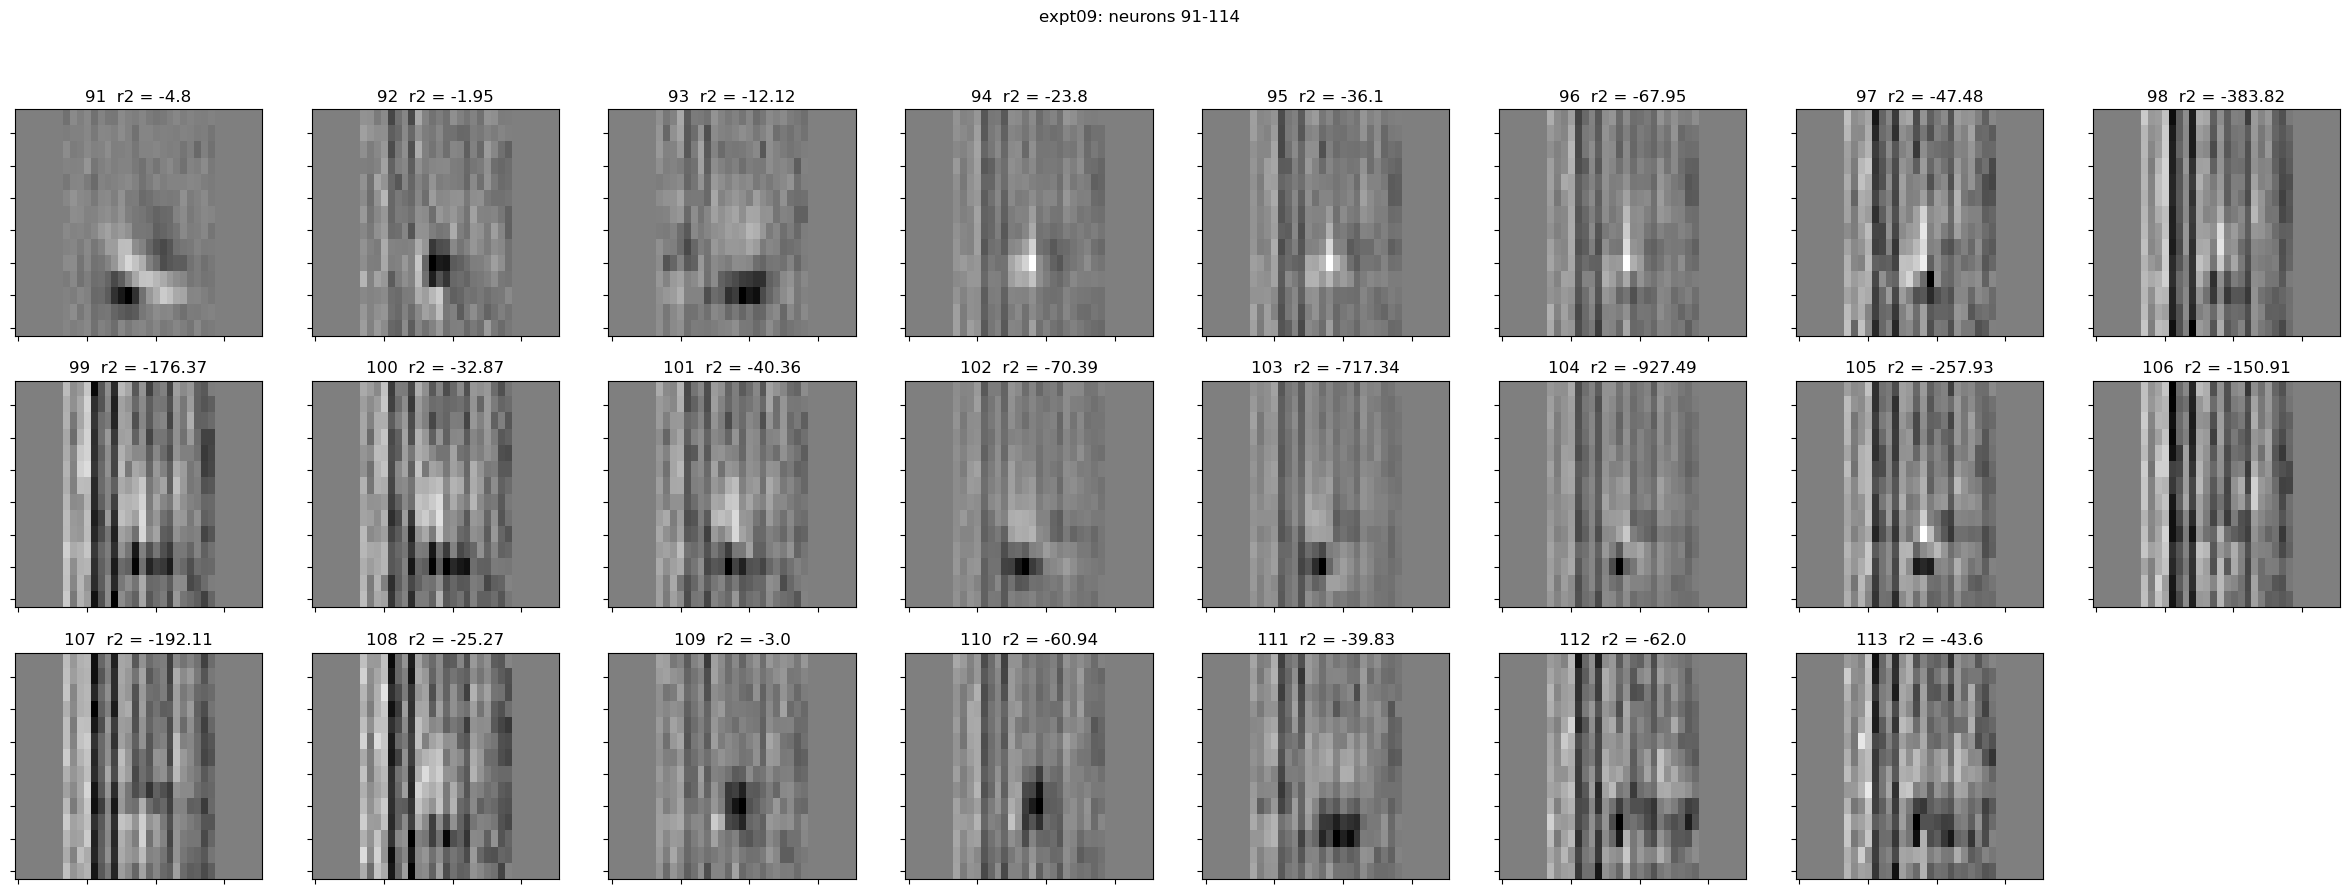

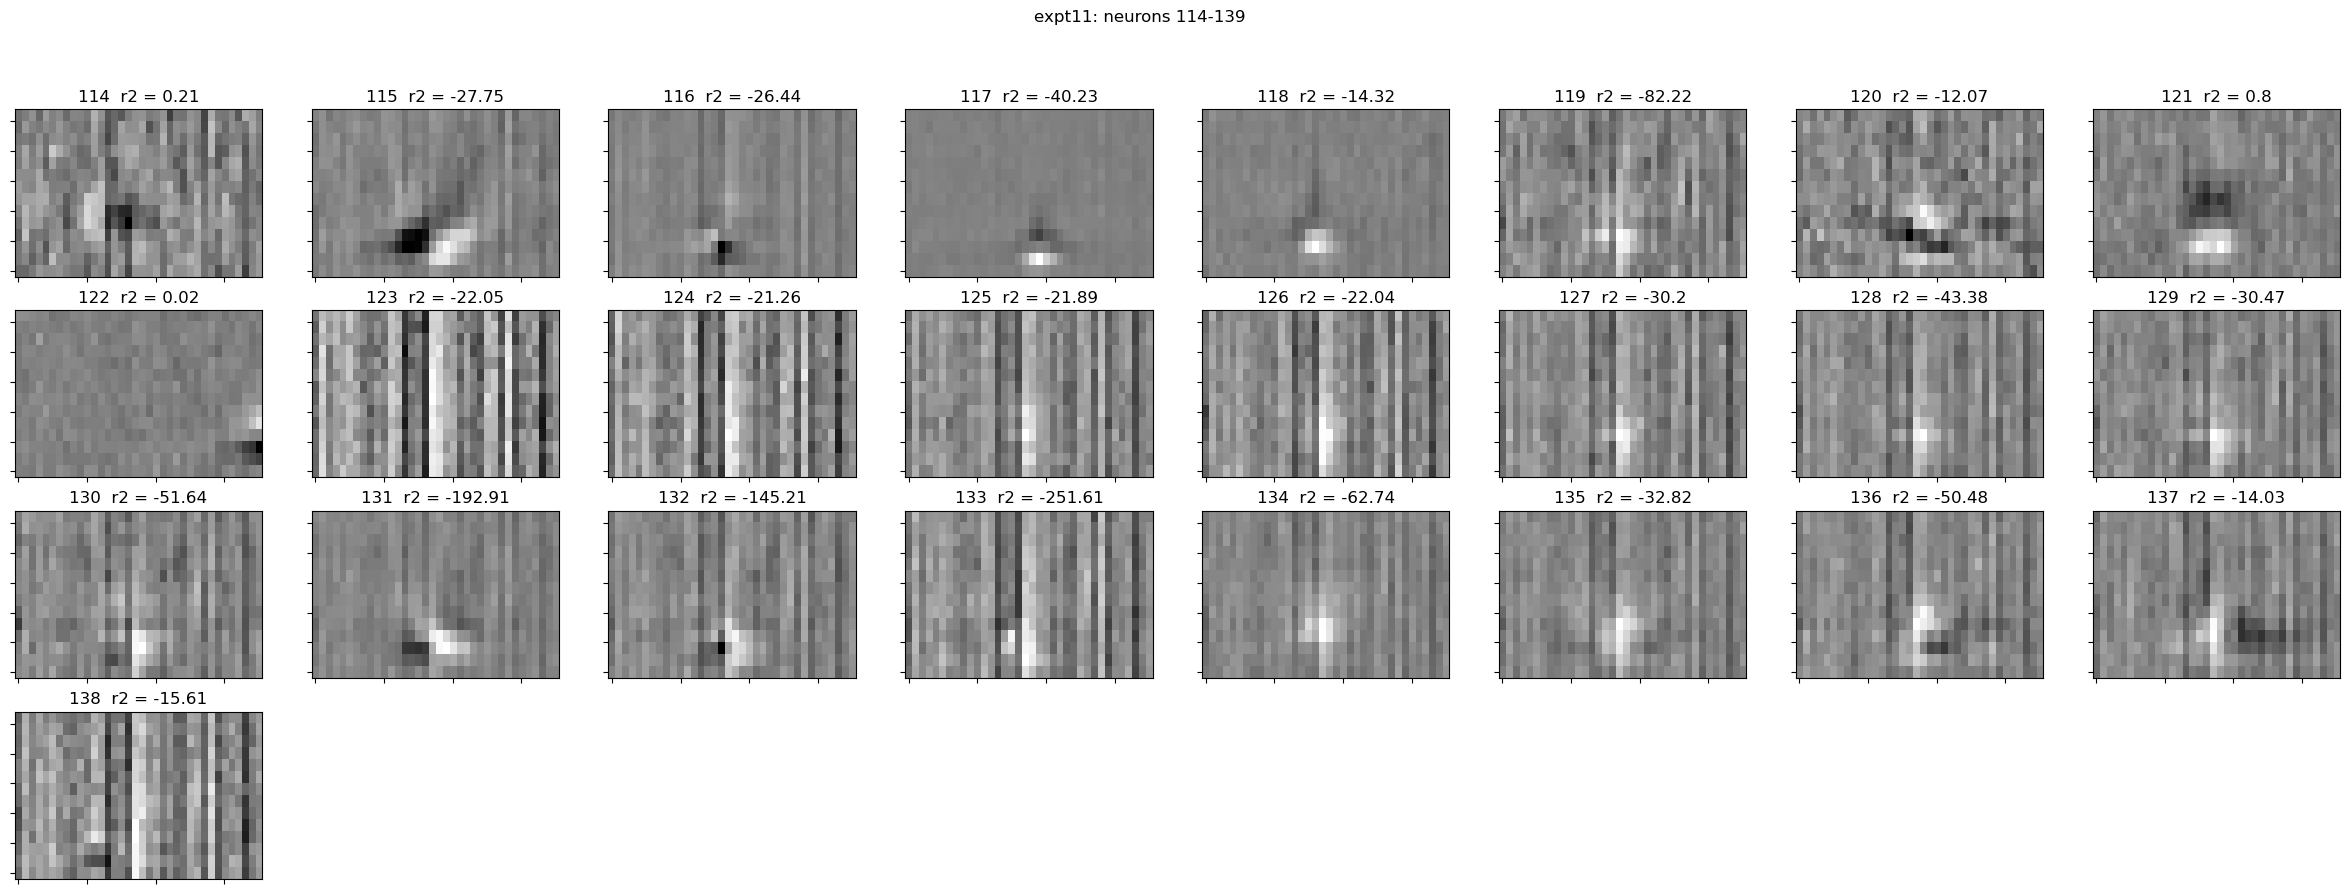

In [607]:
# Calculate STA
num_lags = 14
Reff = dataset.robs * dataset.dfs
nspks = torch.sum(Reff, axis=0)
stas = (dataset.stim.T@dataset.robs / nspks).reshape([-1, num_lags, dataset.NC]).detach().numpy()
print(stas.shape)

# plot first 6 STAs
for expti in range(len(expt_boundaries)-1):
    fig = plt.figure(figsize=(30, 10))
    fig.suptitle(expts[expti]+': neurons '+str(expt_boundaries[expti])+'-'+str(expt_boundaries[expti+1]))
    for i, cc in enumerate(range(expt_boundaries[expti], expt_boundaries[expti+1])):
        expt_len = expt_boundaries[expti+1] - expt_boundaries[expti]
        plt.subplot(expt_len//8+1, 8, i+1)
        plot.imagesc(stas[:, :, cc], aspect='auto', cmap='gray_r', colrow=True, axis_labels=False)
        plt.title(str(cc) + '  r2 = ' + str(round(results_3iter.r2[cc], 2)))

In [82]:
a = torch.tensor([1,2,3])
a.view([-1, 3])

tensor([[1, 2, 3]])

# reweight the subunits

In [13]:
# # reweight the subunits by their connection to the readout layer
# # get the readout layer weights
# readout_weights = model.networks[1].layers[0].weights
# # get the subunit weights
# subunit_weights = model.networks[0].layers[0].weights
# 
# # swap the last and first axes of the subunit weights
# subunit_weights = np.swapaxes(subunit_weights, 0, 2)
# 
# # reweight the subunits
# reweighteds = [] # layer, neuron, subunit
# for neuron in range(11):
#     reweighted_layer = []
#     for layer in range(5):
#         reweighted_neuron = []
#         for i,readout_weight in enumerate(readout_weights[20:30,15,neuron]):
#             reweighted = readout_weight * subunit_weights[i,:,:]
#             reweighted_neuron.append(reweighted)
#         reweighted_layer.append(reweighted_neuron)
#     reweighteds.append(reweighted_layer)
# 
# # get the min and max of the reweighted subunits
# imax = np.max(reweighteds)
# imin = -imax
# print('max: ', imax, 'min: ', imin)
# 
# # plot the reweighted subunits for neuron 1
# fig, axs = plt.subplots(5,10, figsize=(20,6))
# for layer in range(5):
#     for i,reweighted in enumerate(reweighteds[layer][1]):
#         ax = axs[layer,i]
#         ax.imshow(reweighted, cmap='gray', origin='lower', vmin=imin, vmax=imax)
#         ax.axis('off')
# plt.tight_layout()
# plt.suptitle('Reweighted Subunits for Neuron 1', fontsize=20)
# # put spacing between the title and the subplots
# plt.subplots_adjust(top=0.85)
# # label the super axes large font
# fig.text(0.5, 0, 'Subunit', ha='center', va='center', fontsize=16)
# fig.text(0, 0.5, 'Layer', ha='center', va='center', rotation='vertical', fontsize=16)
# plt.show()